# 1. Импорт необходимых библиотек и модулей

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from os import listdir
import pandas as pd
import tensorflow as tf

# print("TensorFlow version:", tf.__version__)

%matplotlib inline

# 2. Чтение данных из файла
## 2.1 Чтение экспериментальных данных из .csv

In [2]:
file_name = 'test.csv'

# TIME_CONSTANT = 0.005
# AMPL = 3.0
# F_PULSE = 20 * 10 ** (-6)
# STDDEV = 0.2

In [3]:
data = pd.read_csv(file_name, 
                   header = 0,
                   parse_dates = [0],
                   infer_datetime_format = True
                  )
data.head()

,frequency_hz,dlts_pf,f_pulse
0,1.0,0.024528,0.00002
1,1.0078626272670832,-0.200976,0.00002
2,1.0157870754417073,0.004056,0.00002
3,1.023773830598626,0.252659,0.00002
4,1.031823382634417,0.307020,0.00002


## 2.2 Подготовка данных для TensorFlow

In [4]:
dlts = tf.Variable(data.dlts_pf.to_numpy(), 
                   dtype = 'float64')

frequency = tf.Variable(data.frequency_hz.to_numpy(),
                        dtype = 'float64')

# filling_pulse = tf.Variable(data.f_pulse.mean() * 10**-6, dtype = 'float64')
filling_pulse = tf.Variable(data.f_pulse.mean(), dtype = 'float64')

In [5]:
# dlts

In [6]:
# frequency

In [7]:
filling_pulse

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.999999999999952e-05>

## 2.3 График

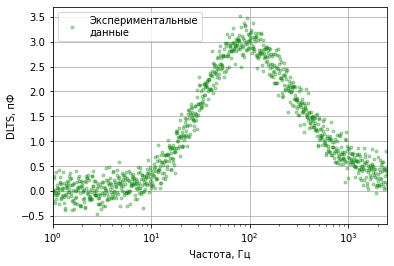

In [8]:
plt.semilogx(frequency.numpy(), dlts.numpy(), '.g', label='Экспериментальные\nданные', alpha = 0.3)
plt.grid()
plt.xlim([1, 2500])
# plt.ylim([-0.006, 0])
plt.legend()
plt.ylabel('DLTS, пФ')
plt.xlabel('Частота, Гц')
plt.show()

## 2.4 Подготовка данных

In [9]:
frequency = np.log10(frequency)
# frequency

In [10]:
scale_factor = np.max(frequency) / (np.max(dlts) - np.min(dlts))
dlts = dlts * scale_factor
# dlts

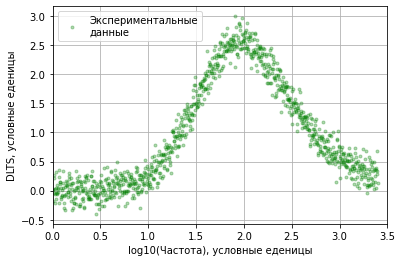

In [11]:
plt.plot(frequency, dlts, '.g', label='Экспериментальные\nданные', alpha=0.3)
plt.grid()
plt.xlim([0, 3.5])
# plt.ylim([-3.5, 0])
plt.legend()
plt.ylabel('DLTS, условные еденицы')
plt.xlabel('log10(Частота), условные еденицы')
plt.show()

# 3. Описание модели
Выходной сигнал коррелятора спектрометра DLS-82E определяется выражением:
\begin{equation}
    \label{eq:eq1}
    S\left(\tau,C_A,F_0, t_1\right) = C_A K_{BS} K_{LS} \phi\left(\tau,F_0,t_1\right),
\end{equation}
где  
$C_A$ - амплитуда емкостного релаксационного сигнала,  
$K_{BS}$ - масштабный коэффициент, зависящий от чувствительности емкостного моста,  
$K_{LS}$ - масштабный коэффициент селектора,  
$\tau$ - постоянная времени релаксации гулбокого уровня,  
$F_0$ - частота сканирования импульсов заполнения,  
$t_1$ - длительность импульса заполнения,  
$\phi\left(\tau,F_0,t_1\right)$ - функция определяемая выражением:  
\begin{equation}
    \label{eq:eq2}
    \phi\left(\tau,F_0,t_1\right) = 
    M \tau F_0 e^{-\frac{0.05}{\tau F_0}}
    \left(1-e^{\frac{t_1 F_0-0.45}{\tau F_0}}
    -e^{-\frac{0.5}{\tau F_0}}+
    e^{\frac{t_1 F_0-0.95}{\tau F_0}}\right),
\end{equation}
где $M$ -- масштабный множитель.

Таким образом,
$$  M = \frac{1}{\max{\left[
    \tau F_0 e^{-\frac{0.05}{\tau F_0}}
    \left(1-e^{\frac{t_1 F_0-0.45}{\tau F_0}}
    -e^{-\frac{0.5}{\tau F_0}}+
    e^{\frac{t_1 F_0-0.95}{\tau F_0}}\right)
    \right]}}
$$

# 4. Кодирование модели
## 4.1 Функция `get_phi()`
$$ \tau = 10^{time\_constant\_power} $$
$$ F_0 = 10^{frequency\_power}$$
$$ a = \tau F_0 $$
$$ b = t_1 F_0 $$
$$ exp0 = \exp{\left(\frac{-0.05}{a}\right)} $$
$$ exp1 = \exp{\left(\frac{b-0.45}{a}\right)} $$
$$ exp2 = \exp{\left(\frac{-0.5}{a}\right)} $$
$$ exp3 = \exp{\left(\frac{b-0.95}{a}\right)} $$
$$ \phi = M \cdot a \cdot exp0 \cdot \left(1.0 - exp1 - exp2 + exp3\right) $$

In [12]:
def get_phi(frequency_power, time_constant_power, M, filling_pulse):
    time_constant = tf.pow(10.0, time_constant_power)
    frequency = tf.pow(10, frequency_power)

    a = time_constant * frequency
    b = filling_pulse * frequency

    exp0 = tf.exp(-0.05 / (a))
    exp1 = tf.exp((b - 0.45) / (a))
    exp2 = tf.exp(-0.5 / (a))
    exp3 = tf.exp((b - 0.95) / (a))

    phi = M * a * exp0 * (1.0 - exp1 - exp2 + exp3)

    return phi

## 4.2 Функция `get_dlts()`
$$ DLTS = A \cdot \phi^{p\_coef} $$

In [13]:
# def get_dlts(amplitude, M, frequency_power, time_constant_power, filling_pulse):
#     dlts = amplitude * get_phi(frequency_power, 
#                                time_constant_power, 
#                                M, 
#                                filling_pulse)
    
#     return dlts

## 4.3 Определение функции потерь для DLTS (для модели). Функция `loss_dlts()`
Среднеквадратическая ошибка


In [14]:
# def loss(target_y, predicted_y):
#     return tf.reduce_mean(tf.square(target_y - predicted_y))

## 4.5 Определение модели для $\phi$

In [15]:
class PhiModel(tf.Module):
    def __init__(self, 
                 time_constant_power,
                 filling_pulse,
                 M = 5.861,
                 **kwargs):
        
        super().__init__(**kwargs)
        
        self.time_constant_power = tf.Variable(time_constant_power, 
                                               dtype='float64', 
                                               name='time constant power'
                                              )
        self.filling_pulse = tf.Variable(filling_pulse, 
                                         dtype='float64',
                                         name='filling pulse'
                                        )
        self.M = tf.Variable(M, 
                             dtype='float64',
                             name='M'
                            )
        
    def __call__(self, frequency_power):
        return get_phi(frequency_power, 
                       self.time_constant_power, 
                       self.M, 
                       self.filling_pulse)
    
    
phi_model = PhiModel(time_constant_power=tf.Variable(-3.0, dtype='float64'), 
                     filling_pulse=filling_pulse)

for i, v in enumerate(phi_model.variables):
    print(f'Variable {i}:', v)

print(phi_model(frequency_power=tf.Variable(3.0, dtype='float64')))

Variable 0: <tf.Variable 'M:0' shape=() dtype=float64, numpy=5.861>
Variable 1: <tf.Variable 'filling pulse:0' shape=() dtype=float64, numpy=1.999999999999952e-05>
Variable 2: <tf.Variable 'time constant power:0' shape=() dtype=float64, numpy=-3.0>
tf.Tensor(0.7666617093509145, shape=(), dtype=float64)


## 4.6 Идентификация коэффициента $M$

In [16]:
def train_M(phi_model,
            learning_rate=0.1,
            n_iters=100,
            stop_val = None,
            verbose = False
           ):
    
    prev_loss = tf.Variable(np.inf, dtype='float64')
    max_freq_pow = tf.Variable(-phi_model.time_constant_power, dtype='float64')
    
    for _ in range(n_iters):
        with tf.GradientTape() as tape:
            current_loss = 0.0 - phi_model(max_freq_pow)
            
        if verbose:
            print(_)
            print(current_loss)
            print(max_freq_pow)
        
        if stop_val is not None:
            if tf.abs(current_loss - prev_loss) < stop_val:
                break
        
        dfreq_pow = tape.gradient(current_loss, max_freq_pow)
        max_freq_pow.assign_sub(learning_rate * dfreq_pow)
        
        prev_loss = current_loss
        
    phi_model.M = phi_model.M / phi_model(max_freq_pow)

In [17]:
train_M(phi_model,
        learning_rate=0.2,
        n_iters=100,
        stop_val = 10**-10,
        verbose = True
       )

0
tf.Tensor(-0.7666617093509145, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.0>
1
tf.Tensor(-0.9330581559008368, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.802874102155242>
2
tf.Tensor(-0.9859552099662315, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.676580828604517>
3
tf.Tensor(-0.9896401527850606, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.640731963100184>
4
tf.Tensor(-0.98970905667989, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.6357570793749963>
5
tf.Tensor(-0.9897099286163724, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.635196461552543>
6
tf.Tensor(-0.9897099390884785, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.635135011043419>
7
tf.Tensor(-0.9897099392135181, shape=(), dtype=float64)
<tf.Variable 'Variable:0' 

In [18]:
phi_model.M

<tf.Tensor: shape=(), dtype=float64, numpy=5.921937092648238>

In [19]:
del phi_model

## 4.7 Определение модели частотного скана

In [20]:
class FeqScanModel(tf.Module):
    
    def __init__(self,
                 amplitude,
                 time_constant_power,
                 filling_pulse,
                 fit_p = False,
                 **kwargs):
        super().__init__(**kwargs)
        
        self.amplitude = tf.Variable(amplitude, dtype='float64')
        
        self.filling_pulse = tf.Variable(filling_pulse, dtype='float64')
        
        self.time_constant_power = tf.Variable(time_constant_power, dtype='float64')
    
        self.phi_model = PhiModel(time_constant_power=self.time_constant_power, 
                                  filling_pulse=self.filling_pulse)
        
        train_M(self.phi_model,
                learning_rate=0.2,
                n_iters=100,
                stop_val = 10**-10,
                verbose = False
               )
        
        self.fit_p = fit_p
        self.p_coef = tf.Variable(1.0, dtype = 'float64')
        
        

    def __call__(self, frequency_power):
        return self.amplitude * self.phi_model(frequency_power) ** self.p_coef
    
    
    def fit(self, 
            f_powers, 
            dlts_vals,
            learning_rate = 0.1,
            n_iters = 1000,
            stop_val = None,
            verbose = False
           ):
        frequency_powers = tf.Variable(f_powers, dtype='float64')
        dlts = tf.Variable(dlts_vals, dtype='float64')
        
        prev_loss = tf.Variable(np.inf, dtype='float64')
        
        for _ in range(n_iters):
            
            train_M(self.phi_model,
                    learning_rate=0.2,
                    n_iters=100,
                    stop_val = 10**-10,
                   )
        
            with tf.GradientTape() as tape:
                predicted_dlts = self.__call__(frequency_powers)
                current_loss = tf.reduce_mean(tf.square(dlts - predicted_dlts))

            if self.fit_p:
                dampl, dtime_const_pow, dp_coef = tape.gradient(current_loss, [self.amplitude, 
                                                                               self.phi_model.time_constant_power,
                                                                               self.p_coef
                                                                              ])
            else:
                dampl, dtime_const_pow = tape.gradient(current_loss, [self.amplitude, 
                                                                      self.phi_model.time_constant_power])

            self.amplitude.assign_sub(learning_rate * dampl)
            self.phi_model.time_constant_power.assign_sub(learning_rate * dtime_const_pow)
            if self.fit_p:
                self.p_coef.assign_sub(learning_rate * dp_coef)
            
            
            self.time_constant_power = self.phi_model.time_constant_power
            
            if verbose:
                print('iter #', _)
                print('amp:',self.amplitude)
                print('tau:',self.time_constant_power)
                print('M:', self.phi_model.M)
                print('p:', self.p_coef)
                print('Loss:', current_loss)
            
            if stop_val is not None:
                if tf.abs(current_loss - prev_loss) < stop_val:
                    break
                    
            prev_loss = current_loss

## 4.8 Проверка модели с $p\_coef = 1$

In [21]:
fs_model = FeqScanModel(amplitude = 2.0,
                        time_constant_power = -2.5,
                        filling_pulse = 20.0*10**-6)

In [22]:
new_frequency = tf.Variable(frequency, dtype='float64')

In [23]:
new_dlts = fs_model(new_frequency)

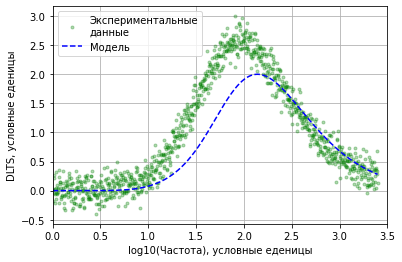

In [24]:
plt.plot(frequency, dlts, '.g', label='Экспериментальные\nданные', alpha=0.3)
plt.plot(new_frequency.numpy(), new_dlts.numpy(), '--b', label='Модель')
plt.grid()
plt.xlim([0, 3.5])
# plt.ylim([-3.5, 0])
plt.legend()
plt.ylabel('DLTS, условные еденицы')
plt.xlabel('log10(Частота), условные еденицы')
plt.show()

In [25]:
fs_model.fit(f_powers = tf.Variable(frequency, dtype='float64'), 
             dlts_vals = tf.Variable(dlts, dtype='float64'),
             learning_rate = 0.2,
             n_iters = 1000,
             stop_val = 10**-10,
             verbose = True
            )

iter # 0
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.0494168469734024>
tau: <tf.Variable 'time constant power:0' shape=() dtype=float64, numpy=-2.3074182665502763>
M: tf.Tensor(5.876559642051986, shape=(), dtype=float64)
p: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.0>
Loss: tf.Tensor(0.2080145378996923, shape=(), dtype=float64)
iter # 1
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.10283576588353>
tau: <tf.Variable 'time constant power:0' shape=() dtype=float64, numpy=-2.2984520638504042>
M: tf.Tensor(5.8690652099080935, shape=(), dtype=float64)
p: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.0>
Loss: tf.Tensor(0.0957038685416496, shape=(), dtype=float64)
iter # 2
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.1506448973083954>
tau: <tf.Variable 'time constant power:0' shape=() dtype=float64, numpy=-2.2989024610835105>
M: tf.Tensor(5.868790910828283, shape=(), dtype=float64)
p: <tf.Variable 'Variable:0' sh

amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.5230484937348168>
tau: <tf.Variable 'time constant power:0' shape=() dtype=float64, numpy=-2.3003762747215406>
M: tf.Tensor(5.868848800008633, shape=(), dtype=float64)
p: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.0>
Loss: tf.Tensor(0.02794013720071633, shape=(), dtype=float64)
iter # 25
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.5267882705819575>
tau: <tf.Variable 'time constant power:0' shape=() dtype=float64, numpy=-2.3003909981163235>
M: tf.Tensor(5.868849300340587, shape=(), dtype=float64)
p: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.0>
Loss: tf.Tensor(0.027857432592785992, shape=(), dtype=float64)
iter # 26
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.5301358447441293>
tau: <tf.Variable 'time constant power:0' shape=() dtype=float64, numpy=-2.3004041747874213>
M: tf.Tensor(5.868849748116459, shape=(), dtype=float64)
p: <tf.Variable 'Variable:0' shape

amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.5562115410640653>
tau: <tf.Variable 'time constant power:0' shape=() dtype=float64, numpy=-2.300506730302505>
M: tf.Tensor(5.868853233378535, shape=(), dtype=float64)
p: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.0>
Loss: tf.Tensor(0.027526049411935583, shape=(), dtype=float64)
iter # 49
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.5564734057776874>
tau: <tf.Variable 'time constant power:0' shape=() dtype=float64, numpy=-2.300507759481046>
M: tf.Tensor(5.868853268355962, shape=(), dtype=float64)
p: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.0>
Loss: tf.Tensor(0.027525643910641506, shape=(), dtype=float64)
iter # 50
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.5567078079728955>
tau: <tf.Variable 'time constant power:0' shape=() dtype=float64, numpy=-2.300508680714476>
M: tf.Tensor(5.868853299664825, shape=(), dtype=float64)
p: <tf.Variable 'Variable:0' shape=(

amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.5585520068618637>
tau: <tf.Variable 'time constant power:0' shape=() dtype=float64, numpy=-2.30051592827453>
M: tf.Tensor(5.868853545979971, shape=(), dtype=float64)
p: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.0>
Loss: tf.Tensor(0.02752401714365105, shape=(), dtype=float64)
iter # 74
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.5585684201099035>
tau: <tf.Variable 'time constant power:0' shape=() dtype=float64, numpy=-2.3005159927741556>
M: tf.Tensor(5.868853548172061, shape=(), dtype=float64)
p: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.0>
Loss: tf.Tensor(0.02752401555060848, shape=(), dtype=float64)
iter # 75
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.558583112053035>
tau: <tf.Variable 'time constant power:0' shape=() dtype=float64, numpy=-2.3005160505094704>
M: tf.Tensor(5.868853550134256, shape=(), dtype=float64)
p: <tf.Variable 'Variable:0' shape=() 

In [26]:
fs_model.amplitude / tf.Variable(scale_factor, dtype='float64')

<tf.Tensor: shape=(), dtype=float64, numpy=2.9944298151433792>

In [27]:
tf.pow(10, fs_model.time_constant_power)

<tf.Tensor: shape=(), dtype=float64, numpy=0.005005916337638267>

In [28]:
fs_model.phi_model.M

<tf.Tensor: shape=(), dtype=float64, numpy=5.868853562450457>

In [29]:
model = fs_model(new_frequency)

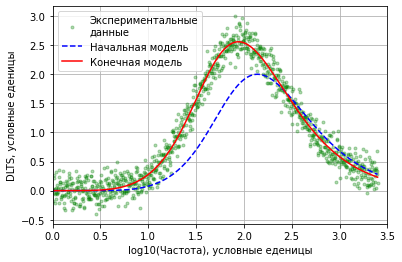

In [30]:
plt.plot(frequency, dlts, '.g', label='Экспериментальные\nданные',alpha=0.3)
plt.plot(new_frequency.numpy(), new_dlts.numpy(), '--b', label='Начальная модель')
plt.plot(new_frequency.numpy(), model.numpy(), 'r', label='Конечная модель')
plt.grid()
plt.xlim([0, 3.5])
# plt.ylim([-3.5, 0])
plt.legend()
plt.ylabel('DLTS, условные еденицы')
plt.xlabel('log10(Частота), условные еденицы')
plt.show()

In [31]:
tf.sqrt(tf.reduce_mean(tf.square(tf.Variable(dlts, dtype='float64') - model)))

<tf.Tensor: shape=(), dtype=float64, numpy=0.16590361483993687>

## 4.9 Проверка модели с коэффициентом $p\_coef \neq 1$

### 4.9.1 Чтение файла

In [32]:
file_name = 'КТ117№1_п1(база 2)_2500Гц-1Гц_1пФ_+10С_-1В-2В_100мВ_20мкс_шаг_0,1.csv'

In [33]:
data = pd.read_csv(file_name, 
                   header = 0,
                   parse_dates = [0],
                   infer_datetime_format = True
                  )
data.head()

,time,frequency_hz,dlts_v,temperature_k,dlts_pf,bs,ls,f_pulse,u1,ur,time_between_meas,integral_time,specimen_name
0,2022-05-06 11:04:58,2500.0000,-2.962,283.160,-0.002962,1,100,20.0,-1.0,-2.0,3.5,3.0,КТ117№1 п1(база 2)
1,2022-05-06 11:05:02,1985.8207,-3.090,283.155,-0.003090,1,100,20.0,-1.0,-2.0,3.5,3.0,КТ117№1 п1(база 2)
2,2022-05-06 11:05:06,1577.3937,-3.359,283.157,-0.003359,1,100,20.0,-1.0,-2.0,3.5,3.0,КТ117№1 п1(база 2)
3,2022-05-06 11:05:10,1252.9686,-3.717,283.143,-0.003717,1,100,20.0,-1.0,-2.0,3.5,3.0,КТ117№1 п1(база 2)
4,2022-05-06 11:05:14,995.2686,-4.068,283.151,-0.004068,1,100,20.0,-1.0,-2.0,3.5,3.0,КТ117№1 п1(база 2)


### 4.9.1 Подготовка данных

In [34]:
frequency = data.frequency_hz.to_numpy()
dlts = data.dlts_pf.to_numpy()

frequency = np.log10(frequency)

scale_factor = np.max(frequency) / (np.max(dlts) - np.min(dlts))
dlts = dlts * scale_factor

In [35]:
dlts = tf.Variable(dlts, dtype = 'float64')

frequency = tf.Variable(frequency, dtype = 'float64')

filling_pulse = tf.Variable(data.f_pulse.mean() * 10**-6, dtype = 'float64')

### 4.9.2 График экспериментальных данных

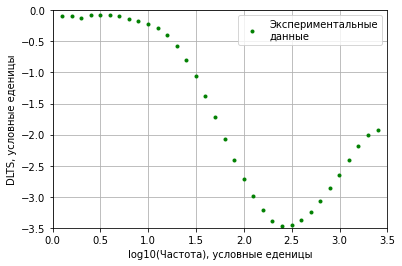

In [36]:
plt.plot(frequency.numpy(), dlts.numpy(), '.g', label='Экспериментальные\nданные', alpha=1)
plt.grid()
plt.xlim([0, 3.5])
plt.ylim([-3.5, 0])
plt.legend()
plt.ylabel('DLTS, условные еденицы')
plt.xlabel('log10(Частота), условные еденицы')
plt.show()

### 4.9.3 Инициализация модели

In [37]:
fs_model = FeqScanModel(amplitude = -2.0,
                        time_constant_power = -2.5,
                        filling_pulse = 20.0*10**-6,
                        fit_p = True
                       )

In [38]:
init_dlts = fs_model(frequency)

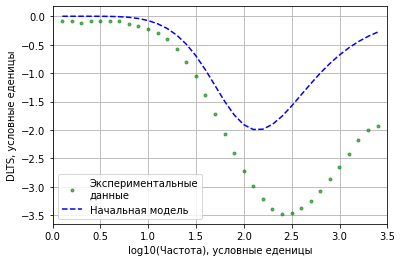

In [39]:
plt.plot(frequency.numpy(), dlts.numpy(), '.g', label='Экспериментальные\nданные', alpha=0.6)
plt.plot(frequency.numpy(), init_dlts.numpy(), '--b', label='Начальная модель')
plt.grid()
plt.xlim([0, 3.5])
# plt.ylim([-3.5, 0])
plt.legend()
plt.ylabel('DLTS, условные еденицы')
plt.xlabel('log10(Частота), условные еденицы')
plt.show()

### 4.9.4 Идентификация модели

In [40]:
fs_model.fit(f_powers = frequency, 
             dlts_vals = dlts,
             learning_rate = 0.2,
             n_iters = 1500,
             stop_val = 10**-10,
             verbose = True
            )

iter # 0
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-2.1855542059198756>
tau: <tf.Variable 'time constant power:0' shape=() dtype=float64, numpy=-2.762711027569307>
M: tf.Tensor(5.876559642051986, shape=(), dtype=float64)
p: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.8325093829875283>
Loss: tf.Tensor(1.349399779469152, shape=(), dtype=float64)
iter # 1
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-2.372445583613232>
tau: <tf.Variable 'time constant power:0' shape=() dtype=float64, numpy=-2.7411343206565384>
M: tf.Tensor(5.893973813623145, shape=(), dtype=float64)
p: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.6630920401388727>
Loss: tf.Tensor(0.8623180729955958, shape=(), dtype=float64)
iter # 2
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-2.5345663191929284>
tau: <tf.Variable 'time constant power:0' shape=() dtype=float64, numpy=-2.751832338177974>
M: tf.Tensor(5.892112594429734, shape=(), dtype=float64)
p

amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-3.3556493187666225>
tau: <tf.Variable 'time constant power:0' shape=() dtype=float64, numpy=-2.8150158139572787>
M: tf.Tensor(5.898969361695377, shape=(), dtype=float64)
p: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.46796936630062913>
Loss: tf.Tensor(0.0070613124543231235, shape=(), dtype=float64)
iter # 25
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-3.3654270382364952>
tau: <tf.Variable 'time constant power:0' shape=() dtype=float64, numpy=-2.81432120482916>
M: tf.Tensor(5.89889054572726, shape=(), dtype=float64)
p: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.4709849951434954>
Loss: tf.Tensor(0.0064634729004265845, shape=(), dtype=float64)
iter # 26
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-3.374402175932488>
tau: <tf.Variable 'time constant power:0' shape=() dtype=float64, numpy=-2.81368093616721>
M: tf.Tensor(5.898821277240916, shape=(), dtype=float64)
p: 

amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-3.4604934471073463>
tau: <tf.Variable 'time constant power:0' shape=() dtype=float64, numpy=-2.807994656210504>
M: tf.Tensor(5.898204177489208, shape=(), dtype=float64)
p: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.5006116283601255>
Loss: tf.Tensor(0.003294980923956864, shape=(), dtype=float64)
iter # 49
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-3.461808255602709>
tau: <tf.Variable 'time constant power:0' shape=() dtype=float64, numpy=-2.8079131932365473>
M: tf.Tensor(5.898195473079162, shape=(), dtype=float64)
p: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.5010261999820613>
Loss: tf.Tensor(0.0032841990839746122, shape=(), dtype=float64)
iter # 50
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-3.4630191322049235>
tau: <tf.Variable 'time constant power:0' shape=() dtype=float64, numpy=-2.807838306257628>
M: tf.Tensor(5.898187474577002, shape=(), dtype=float64)
p:

iter # 73
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-3.475025682492934>
tau: <tf.Variable 'time constant power:0' shape=() dtype=float64, numpy=-2.807102800120109>
M: tf.Tensor(5.898109079770503, shape=(), dtype=float64)
p: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.5052013174579638>
Loss: tf.Tensor(0.003225029920795579, shape=(), dtype=float64)
iter # 74
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-3.4751947600566635>
tau: <tf.Variable 'time constant power:0' shape=() dtype=float64, numpy=-2.807092533323102>
M: tf.Tensor(5.898107987566223, shape=(), dtype=float64)
p: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.5052548148764423>
Loss: tf.Tensor(0.0032248516680236272, shape=(), dtype=float64)
iter # 75
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-3.4753505462154104>
tau: <tf.Variable 'time constant power:0' shape=() dtype=float64, numpy=-2.8070830758267906>
M: tf.Tensor(5.89810698150814, shape=(), dtype=fl

amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-3.4768990876433272>
tau: <tf.Variable 'time constant power:0' shape=() dtype=float64, numpy=-2.8069891820450508>
M: tf.Tensor(5.8980969960433205, shape=(), dtype=float64)
p: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.5057942034933921>
Loss: tf.Tensor(0.0032238692360135085, shape=(), dtype=float64)
iter # 99
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-3.4769209441364857>
tau: <tf.Variable 'time constant power:0' shape=() dtype=float64, numpy=-2.8069878583042414>
M: tf.Tensor(5.898096855299915, shape=(), dtype=float64)
p: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.5058011221706828>
Loss: tf.Tensor(0.003223866257410152, shape=(), dtype=float64)
iter # 100
amp: <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=-3.47694108368758>
tau: <tf.Variable 'time constant power:0' shape=() dtype=float64, numpy=-2.8069866385871154>
M: tf.Tensor(5.898096725617416, shape=(), dtype=float64)

In [41]:
final_dlts = fs_model(frequency)

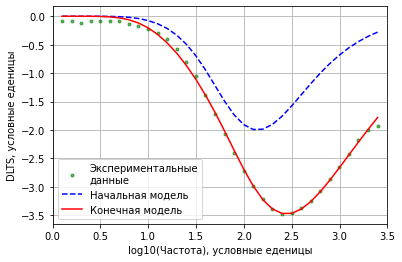

In [42]:
plt.plot(frequency.numpy(), dlts.numpy(), '.g', label='Экспериментальные\nданные', alpha=0.6)
plt.plot(frequency.numpy(), init_dlts.numpy(), '--b', label='Начальная модель')
plt.plot(frequency.numpy(), final_dlts.numpy(), 'r', label='Конечная модель')
plt.grid()
plt.xlim([0, 3.5])
# plt.ylim([-3.5, 0])
plt.legend()
plt.ylabel('DLTS, условные еденицы')
plt.xlabel('log10(Частота), условные еденицы')
plt.show()

In [43]:
fs_model.amplitude / tf.Variable(scale_factor, dtype='float64')

<tf.Tensor: shape=(), dtype=float64, numpy=-0.005351377077024462>

In [44]:
tf.pow(10, fs_model.time_constant_power)

<tf.Tensor: shape=(), dtype=float64, numpy=0.0015596418545129687>

In [45]:
fs_model.phi_model.M

<tf.Tensor: shape=(), dtype=float64, numpy=5.898095500833145>

In [46]:
fs_model.p_coef

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.5058677206625944>

In [47]:
tf.sqrt(tf.reduce_mean(tf.square(final_dlts - dlts)))

<tf.Tensor: shape=(), dtype=float64, numpy=0.05677895701419514>

# 5. Идентификация энергии активации по группе сканов
Эксперементальные данные по GaAs
## 5.1 Чтение данных

In [48]:
def get_file_names(datasets_folder):
    return [datasets_folder + '/' + _ for _ in listdir(datasets_folder)]

def read_datasets(file_names):
    data = pd.read_csv(file_names[0],
                       header=0,
                       parse_dates=[0],
                       infer_datetime_format=True)
    
    for f_name in file_names[1:]:
        data = data.append(pd.read_csv(f_name, header=0, parse_dates=[0], 
                                       infer_datetime_format=True).loc[::10,:],
                           ignore_index = True)
    
    
    return data

In [49]:
DATASET_PATH = '../dataset'

In [50]:
fnames = get_file_names(DATASET_PATH)
data = read_datasets(fnames)

C:\Users\Aleksei\AppData\Local\Temp\ipykernel_5212\1759373501.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.read_csv(f_name, header=0, parse_dates=[0],
C:\Users\Aleksei\AppData\Local\Temp\ipykernel_5212\1759373501.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.read_csv(f_name, header=0, parse_dates=[0],
C:\Users\Aleksei\AppData\Local\Temp\ipykernel_5212\1759373501.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.read_csv(f_name, header=0, parse_dates=[0],
C:\Users\Aleksei\AppData\Local\Temp\ipykernel_5212\1759373501.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conc

In [51]:
data

,time,frequency_hz,dlts_v,temperature_k,dlts_pf,bs,ls,f_pulse,u1,ur,time_between_meas,integral_time,specimen_name
0,2019-04-03 13:40:45,2500.0000,2.3880,313.826,0.011940,10,50,20.0,1.3,-4.0,3.5,3.0,GaAs 3МС
1,2019-04-03 13:40:49,2443.0925,2.3830,313.838,0.011915,10,50,20.0,1.3,-4.0,3.5,3.0,GaAs 3МС
2,2019-04-03 13:40:52,2387.4812,2.3750,313.833,0.011875,10,50,20.0,1.3,-4.0,3.5,3.0,GaAs 3МС
3,2019-04-03 13:40:56,2333.1355,2.3640,313.826,0.011820,10,50,20.0,1.3,-4.0,3.5,3.0,GaAs 3МС
4,2019-04-03 13:40:59,2280.0269,2.3480,313.830,0.011740,10,50,20.0,1.3,-4.0,3.5,3.0,GaAs 3МС
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1423,2019-04-04 14:16:01,3.1473,0.6064,352.986,0.003032,10,50,20.0,1.3,-4.0,3.5,3.0,GaAs 3МС
1424,2019-04-04 14:16:37,2.5000,0.4970,352.985,0.002485,10,50,20.0,1.3,-4.0,3.5,3.0,GaAs 3МС
1425,2019-04-04 14:17:12,1.9858,0.4504,352.997,0.002252,10,50,20.0,1.3,-4.0,3.5,3.0,GaAs 3МС
1426,2019-04-04 14:17:48,1.5774,0.3951,352.988,0.001975,10,50,20.0,1.3,-4.0,3.5,3.0,GaAs 3МС


In [52]:
data = data[['frequency_hz', 'temperature_k', 'dlts_pf']]
data['rounded_temperature'] = data.temperature_k.round()
data

C:\Users\Aleksei\AppData\Local\Temp\ipykernel_5212\2894104208.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rounded_temperature'] = data.temperature_k.round()


,frequency_hz,temperature_k,dlts_pf,rounded_temperature
0,2500.0000,313.826,0.011940,314.0
1,2443.0925,313.838,0.011915,314.0
2,2387.4812,313.833,0.011875,314.0
3,2333.1355,313.826,0.011820,314.0
4,2280.0269,313.830,0.011740,314.0
...,...,...,...,...
1423,3.1473,352.986,0.003032,353.0
1424,2.5000,352.985,0.002485,353.0
1425,1.9858,352.997,0.002252,353.0
1426,1.5774,352.988,0.001975,353.0


## 5.2 График экспериментальных данных

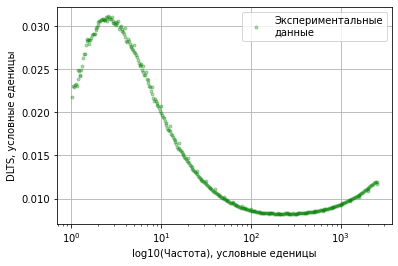

In [53]:
selected = data[data.rounded_temperature == 314]

plt.semilogx(selected.frequency_hz, selected.dlts_pf, '.g', label='Экспериментальные\nданные', alpha=0.3)
plt.grid()
# plt.xlim([0, 3.5])
# plt.ylim([-3.5, 0])
plt.legend()
plt.ylabel('DLTS, условные еденицы')
plt.xlabel('log10(Частота), условные еденицы')
plt.show()

## 5.3 Подготовка данных

In [54]:
frequency = data.frequency_hz.to_numpy()
dlts = data.dlts_pf.to_numpy()
temperature = data.temperature_k.to_numpy()


frequency_power = np.log10(frequency)

scale_factor = np.max(frequency) / (np.max(dlts) - np.min(dlts))
dlts = dlts * scale_factor


frequency_power = tf.Variable(frequency_power, dtype='float64')
dlts = tf.Variable(dlts, dtype='float64')
temperature = tf.Variable(temperature, dtype='float64')

In [55]:
frequency

array([2.5000000e+03, 2.4430925e+03, 2.3874812e+03, ..., 1.9858000e+00,
       1.5774000e+00, 1.2530000e+00])

In [56]:
frequency_power

<tf.Variable 'Variable:0' shape=(1428,) dtype=float64, numpy=
array([3.39794001, 3.38793991, 3.37793996, ..., 0.29793551, 0.19794184,
       0.09795107])>

In [57]:
temperature

<tf.Variable 'Variable:0' shape=(1428,) dtype=float64, numpy=array([313.826, 313.838, 313.833, ..., 352.997, 352.988, 352.982])>

## 5.4 Модель

$$ e_n = BT^2\exp\left(\frac{-\Delta E}{kT} \right) $$
$$ \tau = \frac{1}{e_n} $$
$$ time\_constant\_power = \log_{10}\tau = \frac{\log_e\tau}{\log_e10}$$

$$ F_0 = 10^{frequency\_power}$$
$$ a = \tau F_0 $$
$$ b = t_1 F_0 $$
$$ exp0 = \exp{\left(\frac{-0.05}{a}\right)} $$
$$ exp1 = \exp{\left(\frac{b-0.45}{a}\right)} $$
$$ exp2 = \exp{\left(\frac{-0.5}{a}\right)} $$
$$ exp3 = \exp{\left(\frac{b-0.95}{a}\right)} $$

$$  M = \frac{1}{\max{\left[
    \tau F_0 e^{-\frac{0.05}{\tau F_0}}
    \left(1-e^{\frac{t_1 F_0-0.45}{\tau F_0}}
    -e^{-\frac{0.5}{\tau F_0}}+
    e^{\frac{t_1 F_0-0.95}{\tau F_0}}\right)
    \right]}}
$$

$$ \phi = M \cdot a \cdot exp0 \cdot \left(1.0 - exp1 - exp2 + exp3\right) $$

$$ S\left(\tau,A,F_0, t_1\right) = A \phi\left(\tau,F_0,t_1\right) $$

In [58]:
class DeepLevelModel(tf.Module):
    
    def get_time_constant_power(self, temperature):
        k = tf.Variable(8.617*10**-5, dtype='float64')

        time_constant = 1 / ( self.pre_exp_factor * temperature * temperature * tf.math.exp(-self.energy / (k * temperature) ))

        time_constant_power = tf.math.log(time_constant) / tf.math.log(tf.Variable(10.0, dtype='float64'))

        return time_constant_power
    
    
    def get_phi(self, frequency_power, time_constant_power):
        time_constant = tf.pow(10.0, time_constant_power)
        frequency = tf.pow(10.0, frequency_power)

        a = time_constant * frequency
        b = self.filling_pulse * frequency

        exp0 = tf.exp(-0.05 / (a))
        exp1 = tf.exp((b - 0.45) / (a))
        exp2 = tf.exp(-0.5 / (a))
        exp3 = tf.exp((b - 0.95) / (a))

        phi = self.M * a * exp0 * (1.0 - exp1 - exp2 + exp3)

        return phi
    
    
    def train_M(self,
                time_constant_powers,
                learning_rate=0.1,
                n_iters=100,
                stop_val = None,
                verbose = False
               ):

        prev_loss = tf.Variable(np.inf, dtype='float64')
        max_freq_pow = tf.Variable(-time_constant_powers, dtype='float64')

        for _ in range(n_iters):
            with tf.GradientTape() as tape:
                current_loss = 0.0 - self.get_phi(max_freq_pow, time_constant_powers)

            if verbose:
                print(_)
                print(current_loss)
                print(max_freq_pow)

#             if stop_val is not None:
#                 if tf.abs(current_loss - prev_loss) < stop_val:
#                     break
            if tf.abs(current_loss - prev_loss) < stop_val:
                break

            dfreq_pow = tape.gradient(current_loss, max_freq_pow)
            max_freq_pow.assign_sub(learning_rate * dfreq_pow)

            prev_loss = current_loss

        return self.M / self.get_phi(max_freq_pow, time_constant_powers)
    
    
    def __init__(self,
                 amplitude,
                 energy,
                 pre_exp_factor,
                 filling_pulse,
                 fit_p = False,
                 **kwargs):
        super().__init__(**kwargs)
        
        self.amplitude = tf.Variable(amplitude, dtype='float64')
        self.energy = tf.Variable(energy, dtype='float64')
        self.pre_exp_factor = tf.Variable(pre_exp_factor, dtype='float64')
        self.filling_pulse = tf.Variable(filling_pulse, dtype='float64')
        
        self.fit_p = tf.Variable(fit_p, dtype='bool')
        self.p_coef = tf.Variable(1.0, dtype='float64')
        
        self.M = tf.Variable(5.861, dtype='float64')
        
        
    def __call__(self,frequency_power, temperature):
        time_constant_powers = self.get_time_constant_power(temperature)
        
        def get_M(time_constant_powers):
            
            M = self.train_M(time_constant_powers,
                             learning_rate=0.2,
                             n_iters=100,
                             stop_val = 10**-10,
                             verbose = True
                            )
            
#             print(M)
            
            return M
        
        self.M = tf.map_fn(get_M, time_constant_powers)
        
#         print(self.get_phi(frequency_power, time_constant_powers))
        
        return self.amplitude * self.get_phi(frequency_power, time_constant_powers)
    
    
    def fit(self,
            f_powers, 
            temp_vals,
            dlts_vals,
            
            learning_rate = 0.1,
            n_iters = 1000,
            stop_val = None,
            verbose = False
           ):
        
        frequency_powers = tf.Variable(f_powers, dtype='float64')
        temp = tf.Variable(temp_vals, dtype='float64')
        dlts = tf.Variable(dlts_vals, dtype='float64')
        
        prev_loss = tf.Variable(np.inf, dtype='float64')
        
        for _ in range(n_iters):
        
            with tf.GradientTape() as tape:
                predicted_dlts = self.__call__(frequency_power, temp)
                current_loss = tf.reduse_mean(tf.square(dlts-predicted_dlts))
                
                if self.fit_p:
                    d_ampl, denergy, dpre_exp_factor, pd_coef = tape.gradient(current_loss, [self.amplitude,
                                                                                             self.energy,
                                                                                             self.pre_exp_factor,
                                                                                             self.p_coef
                                                                                            ])
                else:
                    d_ampl, denergy, dpre_exp_factor = tape.gradient(current_loss, [self.amplitude,
                                                                                    self.energy,
                                                                                    self.pre_exp_factor
                                                                                   ])

            self.amplitude.assign_sub(learning_rate * dampl)
            self.energy.assign_sub(learning_rate * denergy)
            self.pre_exp_factor.assign_sub(learning_rate * dpre_exp_factor)
            
            
            if self.fit_p:
                self.p_coef.assign_sub(learning_rate * dp_coef)
                                           
            
            if verbose:
                print('iter #', _)
                print('A:',self.amplitude)
                print('E:',self.energy)
                print('B:', self.pre_exp_factor)
                print('M:', self.phi_model.M)
                print('p:', self.p_coef)
                print('Loss:', current_loss)
            
#             if stop_val is not None:
#                 if tf.abs(current_loss - prev_loss) < stop_val:
#                     break
            if tf.abs(current_loss - prev_loss) < stop_val:
                break
                    
            prev_loss = current_loss

## 5.5 Инициализация и проверка модели

In [59]:
energy = tf.Variable(-0.7, dtype='float64')
pre_exp_factor = tf.Variable(1*10**-13, dtype='float64')
filling_pulse = tf.Variable(2 * 10 ** -5, dtype='float64')
amplitude =tf.Variable(3.5, dtype='float64')

deep_level_model = DeepLevelModel(amplitude = amplitude,
                                  energy = energy,
                                  pre_exp_factor = pre_exp_factor,
                                  filling_pulse = filling_pulse,
                                  fit_p = False)

res  = deep_level_model(frequency_power, temperature)

0
tf.Tensor(-0.7460001644996215, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.2352162149409467>
1
tf.Tensor(-0.9239785979823211, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.031151480273423>
2
tf.Tensor(-0.9785026503577801, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.901874278046204>
3
tf.Tensor(-0.9817171595273012, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8680706443995536>
4
tf.Tensor(-0.981760681861014, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8640845501923082>
5
tf.Tensor(-0.9817610732301434, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.863706047660661>
6
tf.Tensor(-0.9817610765891783, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.863670977555674>
7
tf.Tensor(-0.9817610766178815, shape=(), dtype=float64)
<tf.Varia

2
tf.Tensor(-0.9784824003510773, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.902343024410176>
3
tf.Tensor(-0.9816956231033059, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8685452706248378>
4
tf.Tensor(-0.9817390866198987, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.864561782303528>
5
tf.Tensor(-0.9817394770651114, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.864183718809977>
6
tf.Tensor(-0.9817394804128807, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8641487068286313>
7
tf.Tensor(-0.9817394804414593, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8641454718957333>
0
tf.Tensor(-0.7460115255324323, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.2351170535002574>
1
tf.Tensor(-0.9239834947941209, shape=(), dtype=float64)
<tf.Var

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8641799944201263>
5
tf.Tensor(-0.9817567560903795, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8638015796773444>
6
tf.Tensor(-0.9817567594471593, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8637665211968852>
7
tf.Tensor(-0.981756759475838, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.863763280681485>
0
tf.Tensor(-0.7459622733696054, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.2355467673425866>
1
tf.Tensor(-0.923962266972932, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.031469307568102>
2
tf.Tensor(-0.9784891530835811, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.902186773859463>
3
tf.Tensor(-0.9817028048171662, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.868387059

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.0313103925351537>
2
tf.Tensor(-0.9784959030854242, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.9020305250710137>
3
tf.Tensor(-0.9817099836247506, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8682288503915907>
4
tf.Tensor(-0.9817534863548245, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.864243624514996>
5
tf.Tensor(-0.9817538774159124, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.863865268303335>
6
tf.Tensor(-0.9817538807711899, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8638302175726174>
7
tf.Tensor(-0.9817538807998516, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8638269779877734>
0
tf.Tensor(-0.7460190979380938, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.235050

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.864434517725466>
5
tf.Tensor(-0.9817452386014424, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.864056337132175>
6
tf.Tensor(-0.981745241952214, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8640213096509477>
7
tf.Tensor(-0.9817452419808257, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.864018072857439>
0
tf.Tensor(-0.7460380232972775, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.2348856844865104>
1
tf.Tensor(-0.9239949162196349, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.030833664067661>
2
tf.Tensor(-0.978516136718721, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.901561789293009>
3
tf.Tensor(-0.9817315026222713, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.86775424066

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.0312468272978608>
2
tf.Tensor(-0.9784986023218396, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.9019680260493783>
3
tf.Tensor(-0.981712854334305, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8681655676647337>
4
tf.Tensor(-0.9817563649060833, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8641799944201263>
5
tf.Tensor(-0.9817567560903795, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8638015796773444>
6
tf.Tensor(-0.9817567594471593, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8637665211968852>
7
tf.Tensor(-0.981756759475838, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.863763280681485>
0
tf.Tensor(-0.7460039518338412, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.2351831

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.86446633368717>
5
tf.Tensor(-0.9817437983918957, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8640881823672517>
6
tf.Tensor(-0.9817438017419168, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8640531587609788>
7
tf.Tensor(-0.9817438017705201, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8640499224326432>
0
tf.Tensor(-0.7459736441053186, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.2354475993175105>
1
tf.Tensor(-0.9239671676174218, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.0313739582158425>
2
tf.Tensor(-0.9784932034122912, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.902093024374832>
3
tf.Tensor(-0.9817071124503906, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8682921

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.2353814883982337>
1
tf.Tensor(-0.9239704340747721, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.0313103925351537>
2
tf.Tensor(-0.9784959030854242, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.9020305250710137>
3
tf.Tensor(-0.9817099836247506, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8682288503915907>
4
tf.Tensor(-0.9817534863548245, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.864243624514996>
5
tf.Tensor(-0.9817538774159124, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.863865268303335>
6
tf.Tensor(-0.9817538807711899, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8638302175726174>
7
tf.Tensor(-0.9817538807998516, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.863826

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8643111024541965>
6
tf.Tensor(-0.9817337170114604, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8642761059729054>
7
tf.Tensor(-0.9817337170400058, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8642728729003957>
0
tf.Tensor(-0.7460039518338412, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.2351831609079165>
1
tf.Tensor(-0.9239802303806284, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.0311196981537147>
2
tf.Tensor(-0.9785039994848159, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.901843028853003>
3
tf.Tensor(-0.9817185943593167, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.868039003531218>
4
tf.Tensor(-0.9817621206135086, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.864052

1
tf.Tensor(-0.9239704340747721, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.0313103925351537>
2
tf.Tensor(-0.9784959030854242, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.9020305250710137>
3
tf.Tensor(-0.9817099836247506, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8682288503915907>
4
tf.Tensor(-0.9817534863548245, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.864243624514996>
5
tf.Tensor(-0.9817538774159124, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.863865268303335>
6
tf.Tensor(-0.9817538807711899, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8638302175726174>
7
tf.Tensor(-0.9817538807998516, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8638269779877734>
0
tf.Tensor(-0.7459546912610425, shape=(), dtype=float64)
<tf.Va

6
tf.Tensor(-0.9817510016300954, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8638939144402364>
7
tf.Tensor(-0.9817510016587403, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8638906757858926>
0
tf.Tensor(-0.7459888005568985, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.2353153783568875>
1
tf.Tensor(-0.9239737000210351, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.0312468272978608>
2
tf.Tensor(-0.9784986023218396, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.9019680260493783>
3
tf.Tensor(-0.981712854334305, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8681655676647337>
4
tf.Tensor(-0.9817563649060833, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8641799944201263>
5
tf.Tensor(-0.9817567560903795, shape=(), dtype=float64)
<tf.V

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.901905527310011>
3
tf.Tensor(-0.9817157245791343, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8681022853779248>
4
tf.Tensor(-0.9817592429922847, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.864116364812976>
5
tf.Tensor(-0.9817596342998003, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.863737891543241>
6
tf.Tensor(-0.9817596376580834, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.863702825313086>
7
tf.Tensor(-0.9817596376867783, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.863699583867074>
0
tf.Tensor(-0.7459963768420775, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.2352492691934533>
1
tf.Tensor(-0.9239769654562935, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.031183262

4
tf.Tensor(-0.9817405271169526, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8645299659762067>
5
tf.Tensor(-0.9817409176237402, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8641518732061586>
6
tf.Tensor(-0.98174092097226, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8641168573498264>
7
tf.Tensor(-0.9817409210008465, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8641136219517964>
0
tf.Tensor(-0.7459508997212424, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.2356459373431>
1
tf.Tensor(-0.923957365178041, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.0315646579176336>
2
tf.Tensor(-0.9784851017718329, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.9022805239785066>
3
tf.Tensor(-0.9816984961376829, shape=(), dtype=float64)
<tf.Variab

5
tf.Tensor(-0.981752437904262, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.863897112800777>
6
tf.Tensor(-0.981752441258788, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8638620659449465>
7
tf.Tensor(-0.9817524412874415, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8638588268253593>
0
tf.Tensor(-0.7459546912610425, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.235612880456765>
1
tf.Tensor(-0.9239589992375102, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.031532874356995>
2
tf.Tensor(-0.9784864523183244, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.902249273868353>
3
tf.Tensor(-0.9816999324804451, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8684503434002484>
4
tf.Tensor(-0.9817434077619497, shape=(), dtype=float64)
<tf.Variab

0
tf.Tensor(-0.7459698541836576, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.23548065510638>
1
tf.Tensor(-0.9239655341970638, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.031405741222441>
2
tf.Tensor(-0.978491853411932, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.902124274132534>
3
tf.Tensor(-0.9817056766888839, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.86832377530686>
4
tf.Tensor(-0.9817491676557815, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8643390705716762>
5
tf.Tensor(-0.9817495585320772, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8639608021645127>
6
tf.Tensor(-0.9817495618851013, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8639257630584902>
7
tf.Tensor(-0.9817495619137382, shape=(), dtype=float64)
<tf.Variabl

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.2354475993175105>
1
tf.Tensor(-0.9239671676174218, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.0313739582158425>
2
tf.Tensor(-0.9784932034122912, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.902093024374832>
3
tf.Tensor(-0.9817071124503906, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.868292133558447>
4
tf.Tensor(-0.9817506073384302, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8643072550975393>
5
tf.Tensor(-0.9817509982763203, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8639289574211686>
6
tf.Tensor(-0.9817510016300954, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8638939144402364>
7
tf.Tensor(-0.9817510016587403, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.863890

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.902093024374832>
3
tf.Tensor(-0.9817071124503906, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.868292133558447>
4
tf.Tensor(-0.9817506073384302, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8643072550975393>
5
tf.Tensor(-0.9817509982763203, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8639289574211686>
6
tf.Tensor(-0.9817510016300954, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8638939144402364>
7
tf.Tensor(-0.9817510016587403, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8638906757858926>
0
tf.Tensor(-0.7459546912610425, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.235612880456765>
1
tf.Tensor(-0.9239589992375102, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.0315328

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8646572320166266>
5
tf.Tensor(-0.9817351546909027, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8642792563588113>
6
tf.Tensor(-0.9817351580364205, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8642442560024897>
7
tf.Tensor(-0.9817351580649747, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.864241022464904>
0
tf.Tensor(-0.7459395231594073, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.2357451093191103>
1
tf.Tensor(-0.9239524622324717, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.0316600092642214>
2
tf.Tensor(-0.9784810494767938, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.9023742747316676>
3
tf.Tensor(-0.9816941864116713, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.86857

7
tf.Tensor(-0.981746682074791, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8639862234051545>
0
tf.Tensor(-0.745943315670456, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.2357120517742715>
1
tf.Tensor(-0.9239540966755307, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.0316282253712568>
2
tf.Tensor(-0.9784824003510773, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.902343024410176>
3
tf.Tensor(-0.9816956231033059, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8685452706248378>
4
tf.Tensor(-0.9817390866198987, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.864561782303528>
5
tf.Tensor(-0.9817394770651114, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.864183718809977>
6
tf.Tensor(-0.9817394804128807, shape=(), dtype=float64)
<tf.Varia

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.864211809406598>
5
tf.Tensor(-0.9817553168112815, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.863833423928856>
6
tf.Tensor(-0.9817553201673104, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.863798369323262>
7
tf.Tensor(-0.9817553201959803, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8637951292731465>
0
tf.Tensor(-0.7459850119292012, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.2353484332678195>
1
tf.Tensor(-0.9239720671117845, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.0312786098610776>
2
tf.Tensor(-0.9784972527582169, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.9019992755249167>
3
tf.Tensor(-0.9817114190376236, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8681972

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.901905527310011>
3
tf.Tensor(-0.9817157245791343, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8681022853779248>
4
tf.Tensor(-0.9817592429922847, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.864116364812976>
5
tf.Tensor(-0.9817596342998003, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.863737891543241>
6
tf.Tensor(-0.9817596376580834, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.863702825313086>
7
tf.Tensor(-0.9817596376867783, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.863699583867074>
0
tf.Tensor(-0.7459812229780591, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.2353814883982337>
1
tf.Tensor(-0.9239704340747721, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.031310392

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8639926470307975>
6
tf.Tensor(-0.9817481220237962, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.863957611799696>
7
tf.Tensor(-0.9817481220524248, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8639543740757976>
0
tf.Tensor(-0.74596606393843, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.235513711114737>
1
tf.Tensor(-0.9239639006489043, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.0314375243398626>
2
tf.Tensor(-0.9784905033023649, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.902155523960747>
3
tf.Tensor(-0.9817042408111454, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8683554171652514>
4
tf.Tensor(-0.9817477278568191, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.864370886

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8639862234051545>
0
tf.Tensor(-0.7459698541836576, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.23548065510638>
1
tf.Tensor(-0.9239655341970638, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.031405741222441>
2
tf.Tensor(-0.978491853411932, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.902124274132534>
3
tf.Tensor(-0.9817056766888839, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.86832377530686>
4
tf.Tensor(-0.9817491676557815, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8643390705716762>
5
tf.Tensor(-0.9817495585320772, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8639608021645127>
6
tf.Tensor(-0.9817495618851013, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.86392576305

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.901936776644403>
3
tf.Tensor(-0.9817142895148055, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8681339264663173>
4
tf.Tensor(-0.9817578040073112, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8641481795555808>
5
tf.Tensor(-0.9817581952532156, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8637697355488014>
6
tf.Tensor(-0.9817581986107472, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8637346731934885>
7
tf.Tensor(-0.9817581986394339, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.863731432212789>
0
tf.Tensor(-0.7459850119292012, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.2353484332678195>
1
tf.Tensor(-0.9239720671117845, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.031278

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.864435357668188>
7
tf.Tensor(-0.9817265101686611, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.864432126920849>
0
tf.Tensor(-0.7459471078577248, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.235678994448934>
1
tf.Tensor(-0.9239557309907176, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.0315964415890564>
2
tf.Tensor(-0.9784837511160873, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.902311774159117>
3
tf.Tensor(-0.9816970596786402, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8685136281066965>
4
tf.Tensor(-0.9817405271169526, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8645299659762067>
5
tf.Tensor(-0.9817409176237402, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.86415187

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8687351280420996>
4
tf.Tensor(-0.9817304411931795, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.86475268282631>
5
tf.Tensor(-0.981730831269001, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8643747950135956>
6
tf.Tensor(-0.981730834612269, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8643398062823957>
7
tf.Tensor(-0.9817308346407978, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.864336574139996>
0
tf.Tensor(-0.7459281436832768, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.235844283270675>
1
tf.Tensor(-0.9239475581359518, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.0317553616076456>
2
tf.Tensor(-0.9784769961982095, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.9024680261

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8643047234587637>
0
tf.Tensor(-0.745924349876803, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.235877341693554>
1
tf.Tensor(-0.9239459231812973, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.031787145943604>
2
tf.Tensor(-0.9784756448867385, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.902499276721776>
3
tf.Tensor(-0.981688438481926, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8687034848644437>
4
tf.Tensor(-0.9817318823886824, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.864720865767917>
5
tf.Tensor(-0.9817322725260617, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.864342948672462>
6
tf.Tensor(-0.9817322758700797, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.86430795606

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.868798414727099>
4
tf.Tensor(-0.9817275584528362, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8648163173085694>
5
tf.Tensor(-0.9817279484055491, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8644384880644567>
6
tf.Tensor(-0.9817279517473176, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8644035070833915>
7
tf.Tensor(-0.9817279517758295, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8644002758710463>
0
tf.Tensor(-0.7458636048976854, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.236406306315009>
1
tf.Tensor(-0.9239197465022058, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.0322957103722885>
2
tf.Tensor(-0.9784540090292438, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.902999

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.902436775585916>
3
tf.Tensor(-0.9816913126794602, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8686401988388455>
4
tf.Tensor(-0.9817347644303983, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8646572320166266>
5
tf.Tensor(-0.9817351546909027, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8642792563588113>
6
tf.Tensor(-0.9817351580364205, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8642442560024897>
7
tf.Tensor(-0.9817351580649747, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.864241022464904>
0
tf.Tensor(-0.7458939877608874, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.2361418169792704>
1
tf.Tensor(-0.9239328389379337, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.032041

tf.Tensor(-0.9817207425751884, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.864559532348444>
0
tf.Tensor(-0.7458598055802136, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.236439368469924>
1
tf.Tensor(-0.9239181093714539, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.032327496589506>
2
tf.Tensor(-0.9784526558580482, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.9030305477340943>
3
tf.Tensor(-0.981663989004234, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8692414338262395>
4
tf.Tensor(-0.9817073662221526, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.865261772324891>
5
tf.Tensor(-0.9817077553134211, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8648843531774326>
6
tf.Tensor(-0.9817077586447013, shape=(), dtype=float64)
<tf.Variabl

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8472718526327503>
5
tf.Tensor(-0.982506215164595, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8468780191934306>
6
tf.Tensor(-0.9825062189327284, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.846840901694988>
7
tf.Tensor(-0.9825062189660388, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8468374118113604>
0
tf.Tensor(-0.7479194047286203, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.2181235646213358>
1
tf.Tensor(-0.9248073113409356, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.014703374922185>
2
tf.Tensor(-0.9791870997605056, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8856969009100704>
3
tf.Tensor(-0.982445077026491, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.85169555

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8469009766287203>
0
tf.Tensor(-0.747944765338866, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.2178929847852444>
1
tf.Tensor(-0.92481828188344, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.014481312026017>
2
tf.Tensor(-0.979196154433521, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8854784243155716>
3
tf.Tensor(-0.9824547065602118, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8514744761273647>
4
tf.Tensor(-0.982500275188884, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.847398850633955>
5
tf.Tensor(-0.982500699270702, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.847005131987179>
6
tf.Tensor(-0.9825007030356573, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8469680299462

5
tf.Tensor(-0.9824730931139865, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.847640726191468>
6
tf.Tensor(-0.98247309686307, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8476037014445215>
7
tf.Tensor(-0.9824730968961627, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.847600222884167>
0
tf.Tensor(-0.7478504926852376, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.218749478116988>
1
tf.Tensor(-0.9247775038732226, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.01530614545212>
2
tf.Tensor(-0.9791624969988026, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.886289927606327>
3
tf.Tensor(-0.9824189122645118, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.852295653881868>
4
tf.Tensor(-0.9824643801408468, shape=(), dtype=float64)
<tf.Variable 

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.825830239097536>
3
tf.Tensor(-0.9848965251696932, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.7911776586433743>
4
tf.Tensor(-0.9849493206752281, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.7868017435010253>
5
tf.Tensor(-0.9849498689803863, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.7863551265880537>
6
tf.Tensor(-0.9849498744031532, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.7863107044219246>
7
tf.Tensor(-0.9849498744565198, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.7863062975534287>
0
tf.Tensor(-0.7543422241431256, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.155277373446361>
1
tf.Tensor(-0.9276024300034451, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.954014

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.786463957798035>
0
tf.Tensor(-0.7543113865261192, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.15560263739948>
1
tf.Tensor(-0.9275889295500657, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.9543290886696347>
2
tf.Tensor(-0.981477987729617, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.826233855878347>
3
tf.Tensor(-0.9848811908554482, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.7915852790331876>
4
tf.Tensor(-0.9849339387720677, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.787211267634574>
5
tf.Tensor(-0.9849344862156436, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.786764995081255>
6
tf.Tensor(-0.9849344916263177, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.78672062181

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.7866704080105067>
6
tf.Tensor(-0.9849380429156882, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.786626023458904>
7
tf.Tensor(-0.9849380429689361, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.786621621434558>
0
tf.Tensor(-0.7543298921909021, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.1554074764550726>
1
tf.Tensor(-0.9275970310836621, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.9541401425455205>
2
tf.Tensor(-0.9814846457928931, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.82604756923367>
3
tf.Tensor(-0.984888270213376, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.791397143942015>
4
tf.Tensor(-0.984941040096754, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.78702225367

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.9195476608589153>
2
tf.Tensor(-0.982654022770596, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.791923145909356>
3
tf.Tensor(-0.9861315512741583, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.7569510058177746>
4
tf.Tensor(-0.9861882728758404, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.7524210472528896>
5
tf.Tensor(-0.9861888942143384, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.7519461872216597>
6
tf.Tensor(-0.9861889006902337, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.7518977006760115>
7
tf.Tensor(-0.98618890075738, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.7518927633706753>
0
tf.Tensor(-0.757556777938465, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.119919380

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.7516731020901326>
0
tf.Tensor(-0.7575933510476254, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.119499593712988>
1
tf.Tensor(-0.9290301085548248, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.9193282382816954>
2
tf.Tensor(-0.9826611345233087, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.791706575707803>
3
tf.Tensor(-0.9861391119038209, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.7567324969071394>
4
tf.Tensor(-0.9861958581115162, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.7522015910200666>
5
tf.Tensor(-0.9861964799198265, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.7517265549893732>
6
tf.Tensor(-0.9861964864026714, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.751678

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.7517721810403786>
7
tf.Tensor(-0.9861932359668001, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.75176724179696>
0
tf.Tensor(-0.7576074071389954, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.119338146811113>
1
tf.Tensor(-0.9290362998347504, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.9191715118847528>
2
tf.Tensor(-0.9826662119260151, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.791551885793591>
3
tf.Tensor(-0.9861445097755336, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.7565764229926635>
4
tf.Tensor(-0.9862012735548411, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.7520448407383964>
5
tf.Tensor(-0.9862018956987433, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.75156967

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.721826462649715>
5
tf.Tensor(-0.9872089438699573, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.7213275977775466>
6
tf.Tensor(-0.9872089513395074, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.721275575015786>
7
tf.Tensor(-0.9872089514202752, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.721270165321467>
0
tf.Tensor(-0.7602013335655019, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.0884382872043403>
1
tf.Tensor(-0.9301816180130194, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8891427794048883>
2
tf.Tensor(-0.9836047010019854, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.7619001705675736>
3
tf.Tensor(-0.9871421640533663, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.7266707

2
tf.Tensor(-0.983608464050964, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.761776829047068>
3
tf.Tensor(-0.9871461640462412, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.7265464313832504>
4
tf.Tensor(-0.9872062504902049, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.7218888902294527>
5
tf.Tensor(-0.9872069374573632, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.7213900732440717>
6
tf.Tensor(-0.9872069449248378, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.7213380576099118>
7
tf.Tensor(-0.9872069450055767, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.7213326488775613>
0
tf.Tensor(-0.7602220985660393, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.0881816045882773>
1
tf.Tensor(-0.9301908088273376, shape=(), dtype=float64)
<tf.Va

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.0882457739813884>
1
tf.Tensor(-0.9301885116574335, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.888955496797563>
2
tf.Tensor(-0.9836103451293445, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.7617151589451474>
3
tf.Tensor(-0.9871481635675723, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.7264842561278453>
4
tf.Tensor(-0.9872082567682262, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.721826462649715>
5
tf.Tensor(-0.9872089438699573, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.7213275977775466>
6
tf.Tensor(-0.9872089513395074, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.721275575015786>
7
tf.Tensor(-0.9872089514202752, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.7212701

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.690255760856016>
6
tf.Tensor(-0.9881707297509627, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.6902002420788325>
7
tf.Tensor(-0.9881707298467602, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.6901943559163577>
0
tf.Tensor(-0.7627156949953526, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.056169981458287>
1
tf.Tensor(-0.9312970768071586, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8577188802025257>
2
tf.Tensor(-0.9845172705449304, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.7308440006711>
3
tf.Tensor(-0.9881121205032358, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.6953713063571416>
4
tf.Tensor(-0.9881755290839971, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.690591468

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8579674633657977>
2
tf.Tensor(-0.9845103166375944, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.7310897775734517>
3
tf.Tensor(-0.988104729882868, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.69561892385999>
4
tf.Tensor(-0.9881681126023253, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.6908400250684306>
5
tf.Tensor(-0.9881688665360769, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.690317946223597>
6
tf.Tensor(-0.9881688750568244, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.6902624343418715>
7
tf.Tensor(-0.9881688751525908, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.6902565491281343>
0
tf.Tensor(-0.7627013485008036, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.05636123

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.690405057825502>
5
tf.Tensor(-0.9881818432541988, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.689882661005961>
6
tf.Tensor(-0.9881818517899792, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.689827100866238>
7
tf.Tensor(-0.9881818518859641, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.68982120901201>
0
tf.Tensor(-0.7627133044006666, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.056201856696028>
1
tf.Tensor(-0.9312960137874949, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8577499525987298>
2
tf.Tensor(-0.9845164015457144, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.7308747223777994>
3
tf.Tensor(-0.9881111969304217, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.6954022580

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.664390591868683>
5
tf.Tensor(-0.9889340324146112, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.663849573914362>
6
tf.Tensor(-0.9889340418613672, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.663791166086926>
7
tf.Tensor(-0.9889340419708055, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.663784879389611>
8
tf.Tensor(-0.9889340419720722, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.6637842029438237>
0
tf.Tensor(-0.7646588165977654, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.0294364074092894>
1
tf.Tensor(-0.9321626753909299, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.831637871284692>
2
tf.Tensor(-0.9852244649085112, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.705048705

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.0294364074092894>
1
tf.Tensor(-0.9321626753909299, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.831637871284692>
2
tf.Tensor(-0.9852244649085112, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.7050487053728944>
3
tf.Tensor(-0.9888636775049703, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.6693899039635594>
4
tf.Tensor(-0.9889297519020187, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.664514371541585>
5
tf.Tensor(-0.9889305624584004, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.6639734403471165>
6
tf.Tensor(-0.9889305719007709, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.663915045885595>
7
tf.Tensor(-0.9889305720101433, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.6639087

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.664050210005974>
5
tf.Tensor(-0.9889435691904188, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.6635089535611773>
6
tf.Tensor(-0.9889435786492369, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.66345050898805>
7
tf.Tensor(-0.9889435787588557, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.663444217157831>
8
tf.Tensor(-0.9889435787601258, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.6634435400331045>
0
tf.Tensor(-0.7646945127009266, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.0289292213554835>
1
tf.Tensor(-0.9321786059469883, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8311426731745186>
2
tf.Tensor(-0.9852374724367666, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.70455876

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.628718399086134>
5
tf.Tensor(-0.9898927224545947, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.628153105697616>
6
tf.Tensor(-0.9898927331816154, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.628090922585935>
7
tf.Tensor(-0.9898927333106051, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.628084103604788>
8
tf.Tensor(-0.9898927333121554, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.628083356093046>
0
tf.Tensor(-0.767134823810898, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.9927389952849177>
1
tf.Tensor(-0.9332701654867224, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.795771985077069>
2
tf.Tensor(-0.9861280913008061, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.66954881142

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.9929592353896943>
1
tf.Tensor(-0.9332637851527458, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.795987445549249>
2
tf.Tensor(-0.9861228892130502, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.669762162017925>
3
tf.Tensor(-0.989818308781461, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.63387000489993>
4
tf.Tensor(-0.989887872750855, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.62887225802238>
5
tf.Tensor(-0.9898887592782183, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.628307066240285>
6
tf.Tensor(-0.9898887699996568, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.62824489907655>
7
tf.Tensor(-0.9898887701285596, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.628238082364552

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.6285645439315855>
5
tf.Tensor(-0.9898966840883769, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.6279991489657863>
6
tf.Tensor(-0.9898966948209805, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.6279369499095147>
7
tf.Tensor(-0.9898966949500572, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.627930128659524>
8
tf.Tensor(-0.9898966949516083, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.6279293808420716>
0
tf.Tensor(-0.767134823810898, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.9927389952849177>
1
tf.Tensor(-0.9332701654867224, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.795771985077069>
2
tf.Tensor(-0.9861280913008061, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.6695488

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.607976667061827>
8
tf.Tensor(-0.990398056359503, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.6079758797306183>
0
tf.Tensor(-0.76843372398503, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.97214367243861>
1
tf.Tensor(-0.9338531721228811, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.7756128762903702>
2
tf.Tensor(-0.986603253229164, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.6495825595572615>
3
tf.Tensor(-0.9903286503077305, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.6135670449122874>
4
tf.Tensor(-0.990400127698413, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.608503667408362>
5
tf.Tensor(-0.9904010570994168, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.6079252551657

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.971736417798913>
1
tf.Tensor(-0.93386443258309, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.7752140366383586>
2
tf.Tensor(-0.9866124272050325, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.649187446101639>
3
tf.Tensor(-0.9903383962616269, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.6131695851476326>
4
tf.Tensor(-0.9904099105194961, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.6081049523373965>
5
tf.Tensor(-0.9904108407549853, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.607526285921074>
6
tf.Tensor(-0.9904108522335041, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.6074619932065333>
7
tf.Tensor(-0.9904108523742976, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.607454872

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.6489443102451893>
3
tf.Tensor(-0.9903443888810485, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.6129250067617327>
4
tf.Tensor(-0.9904159258140084, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.607859602048968>
5
tf.Tensor(-0.990416856562904, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.6072807793138937>
6
tf.Tensor(-0.9904168680504052, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.607216461816128>
7
tf.Tensor(-0.9904168681913408, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.6072093376007266>
8
tf.Tensor(-0.9904168681930694, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.607208548754686>
0
tf.Tensor(-0.7684510739340681, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.97186172

7
tf.Tensor(-0.9904228802756032, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.6069638125094428>
8
tf.Tensor(-0.9904228802773334, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.6069630231787797>
0
tf.Tensor(-0.7684510739340681, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.971861723265718>
1
tf.Tensor(-0.9338609690175191, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.775336753809825>
2
tf.Tensor(-0.9866096054280211, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.649309017140308>
3
tf.Tensor(-0.99033539855493, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.6132918778374883>
4
tf.Tensor(-0.990406901471709, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.6082276311480976>
5
tf.Tensor(-0.9904078314504597, shape=(), dtype=float64)
<tf.Variab

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.9286679471057235>
1
tf.Tensor(-0.9349992269442087, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.7329916217639165>
2
tf.Tensor(-0.9875362780019815, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.6073407871846324>
3
tf.Tensor(-0.9913197406177958, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.571088480699589>
4
tf.Tensor(-0.9913950301763665, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.5658970789224824>
5
tf.Tensor(-0.991396047538106, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.565292491738336>
6
tf.Tensor(-0.9913960605699611, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.5652240508383644>
7
tf.Tensor(-0.9913960607358651, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.5652163

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.5650748092987143>
5
tf.Tensor(-0.9914142816561081, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.564469736291717>
6
tf.Tensor(-0.9914142947183202, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.564401216907753>
7
tf.Tensor(-0.9914142948847239, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.56439348303678>
8
tf.Tensor(-0.9914142948868425, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.5643926104281065>
0
tf.Tensor(-0.7710349378208384, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.927643488041606>
1
tf.Tensor(-0.9350249108809546, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.7319862663757046>
2
tf.Tensor(-0.9875571723374076, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.606343941

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.564087881262608>
0
tf.Tensor(-0.7710435437142226, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.927488285996979>
1
tf.Tensor(-0.9350287967716215, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.7318339544774988>
2
tf.Tensor(-0.9875603335196451, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.6061929174332614>
3
tf.Tensor(-0.9913452902695369, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.5699345549310166>
4
tf.Tensor(-0.9914206797934862, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.5647398430537907>
5
tf.Tensor(-0.9914216995070573, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.564134572345098>
6
tf.Tensor(-0.9914217125816362, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.5640660

3
tf.Tensor(-0.9917709412928755, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.550229789443365>
4
tf.Tensor(-0.9918480087787678, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.5449798616856456>
5
tf.Tensor(-0.9918490683120966, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.5443631388268355>
6
tf.Tensor(-0.9918490821162343, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.54429272940553>
7
tf.Tensor(-0.9918490822949588, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.5442847176298478>
8
tf.Tensor(-0.991849082297271, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.5442838063279685>
0
tf.Tensor(-0.7721125891767738, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.9077564097419524>
1
tf.Tensor(-0.9355119889235611, shape=(), dtype=float64)
<tf.Vari

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.5447179149795396>
7
tf.Tensor(-0.9918401005282901, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.544709909020901>
8
tf.Tensor(-0.9918401005305981, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.544708998532123>
0
tf.Tensor(-0.7721076792926932, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.907849148840424>
1
tf.Tensor(-0.9355097675666619, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.7125521895885774>
2
tf.Tensor(-0.9879514866574848, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.5870705592923358>
3
tf.Tensor(-0.9917607172003532, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.5507140689587002>
4
tf.Tensor(-0.991837744103507, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.54546546

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.908343787623092>
1
tf.Tensor(-0.9354979117978364, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.713038027637492>
2
tf.Tensor(-0.9879418476629342, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.587552467027367>
3
tf.Tensor(-0.9917504805304153, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.5511983869847903>
4
tf.Tensor(-0.9918274668146487, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.5459511164386828>
5
tf.Tensor(-0.9918285244060867, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.5453349468752866>
6
tf.Tensor(-0.9918285381743773, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.545264627566093>
7
tf.Tensor(-0.9918285383525021, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.54525662

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.554953397445991>
3
tf.Tensor(-0.9924169661938796, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.5184432014007534>
4
tf.Tensor(-0.9924966258419007, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.513109220787388>
5
tf.Tensor(-0.992497748157849, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.5124748828145074>
6
tf.Tensor(-0.9924977631355207, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.512401586578837>
7
tf.Tensor(-0.9924977633341286, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.512393146062375>
8
tf.Tensor(-0.9924977633367605, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.5123921744650723>
0
tf.Tensor(-0.773772421421315, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8751924766

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.5135191852891214>
7
tf.Tensor(-0.9924758444601522, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.513510759539891>
8
tf.Tensor(-0.9924758444627725, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.5135097900312253>
0
tf.Tensor(-0.7737256732973361, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.876144376094686>
1
tf.Tensor(-0.9362428714212849, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.6813907932679437>
2
tf.Tensor(-0.9885472439370334, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.556152290574067>
3
tf.Tensor(-0.99239336545459, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.5196475945364907>
4
tf.Tensor(-0.9924729294369958, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.514316689

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.5136910455176227>
0
tf.Tensor(-0.7737030125251207, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8766050406151824>
1
tf.Tensor(-0.9362325889603198, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.681843847544297>
2
tf.Tensor(-0.9885388915649139, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.5566019334679666>
3
tf.Tensor(-0.9923844965647085, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.5200993048053544>
4
tf.Tensor(-0.9924640246160812, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.51476955582413>
5
tf.Tensor(-0.9924651437077961, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.5141361099315858>
6
tf.Tensor(-0.9924651586245191, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.5140629

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.5145590445272243>
6
tf.Tensor(-0.9924568374163786, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.5144859328115783>
7
tf.Tensor(-0.9924568376136769, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.5144775198516878>
8
tf.Tensor(-0.992456837616287, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.514476552151235>
0
tf.Tensor(-0.7736833516759748, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8770043190846586>
1
tf.Tensor(-0.9362236680776551, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.68223652324399>
2
tf.Tensor(-0.9885316451092752, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.5569916495416414>
3
tf.Tensor(-0.9923768019661028, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.52049081

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.491169272842867>
4
tf.Tensor(-0.9930155561583587, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.4857678384437767>
5
tf.Tensor(-0.9930167307931992, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.4851192052558364>
6
tf.Tensor(-0.9930167467699736, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.4850435409456226>
7
tf.Tensor(-0.9930167469858738, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.485034744961485>
8
tf.Tensor(-0.9930167469887895, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.485033722838394>
0
tf.Tensor(-0.7751067449572161, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.847089582799833>
1
tf.Tensor(-0.9368703456697749, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.65279980

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.485644721617239>
7
tf.Tensor(-0.9930056974526417, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.485635933318407>
8
tf.Tensor(-0.9930056974555505, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.485634912292708>
0
tf.Tensor(-0.7750772747823098, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8477306136550937>
1
tf.Tensor(-0.9368569396900754, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.6534309437482775>
2
tf.Tensor(-0.9890458600320532, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.5283962342674937>
3
tf.Tensor(-0.9929227800991368, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.491768658304871>
4
tf.Tensor(-0.9930045077809866, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.48636866

tf.Tensor(-0.9930040385746495, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.485726117098196>
8
tf.Tensor(-0.9930040385775579, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.4857250962371675>
0
tf.Tensor(-0.7750800835373063, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8476695593843133>
1
tf.Tensor(-0.9368582173613439, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.653370832751233>
2
tf.Tensor(-0.989046897103886, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.5283365474295247>
3
tf.Tensor(-0.9929238811535318, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.4917087169900056>
4
tf.Tensor(-0.9930056133740643, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.486308576712022>
5
tf.Tensor(-0.9930067869886762, shape=(), dtype=float64)
<tf.Variab

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.498476084556019>
3
tf.Tensor(-0.993455529013811, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.461725904198025>
4
tf.Tensor(-0.9935394715875042, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.4562561864158696>
5
tf.Tensor(-0.9935407009817071, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.455592938235752>
6
tf.Tensor(-0.9935407180242063, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.455514829715583>
7
tf.Tensor(-0.9935407182589028, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.4555056633575556>
8
tf.Tensor(-0.9935407182621321, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.455504588091405>
0
tf.Tensor(-0.7764235133814231, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8174220336

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.455473352412775>
6
tf.Tensor(-0.993542767205052, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.4553952342275336>
7
tf.Tensor(-0.9935427674398247, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.4553860663980367>
8
tf.Tensor(-0.9935427674430553, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.455384990919759>
0
tf.Tensor(-0.7764443047639961, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8169367213292325>
1
tf.Tensor(-0.9374795613018494, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.623096145746825>
2
tf.Tensor(-0.9895510493546201, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.498268197701769>
3
tf.Tensor(-0.993459099314004, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.4615171992

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.8164211312597827>
1
tf.Tensor(-0.937489622644845, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.622587965084122>
2
tf.Tensor(-0.989559209993261, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.497763359284502>
3
tf.Tensor(-0.9934677621810063, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.4610103759978808>
4
tf.Tensor(-0.9935517560579329, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.4555390549928626>
5
tf.Tensor(-0.9935529867598746, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.4548754619279394>
6
tf.Tensor(-0.993553003828071, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.4547972954486843>
7
tf.Tensor(-0.993553004063225, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.4547881202

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.421106599972565>
5
tf.Tensor(-0.99411919282508, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.420427003007288>
6
tf.Tensor(-0.9941192111139125, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.4203461329060225>
7
tf.Tensor(-0.9941192113710291, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.4203365439276>
8
tf.Tensor(-0.9941192113746409, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.4203354074203256>
0
tf.Tensor(-0.7778842974667193, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.781913272457889>
1
tf.Tensor(-0.9381370950692985, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.5885562945184497>
2
tf.Tensor(-0.990084166392806, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.4639468398898

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.4206633521986847>
8
tf.Tensor(-0.9941140522707961, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.4206622162497364>
0
tf.Tensor(-0.7778973601595315, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.7815821039108424>
1
tf.Tensor(-0.9381430676939118, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.588229512859922>
2
tf.Tensor(-0.9900890070342955, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.463622043528836>
3
tf.Tensor(-0.9940301203202708, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.4267408082365813>
4
tf.Tensor(-0.9941164942039267, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.421195679693664>
5
tf.Tensor(-0.9941177862222955, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.4205161

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.421195679693664>
5
tf.Tensor(-0.9941177862222955, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.420516122751722>
6
tf.Tensor(-0.9941178045080061, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.420435259446117>
7
tf.Tensor(-0.9941178047650662, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.4204256715130015>
8
tf.Tensor(-0.994117804768677, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.420424535157974>
0
tf.Tensor(-0.7779068533960796, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.7813412686138266>
1
tf.Tensor(-0.9381474083534941, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.5879918657087977>
2
tf.Tensor(-0.9900925249939079, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.463385839

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.4208701957059007>
0
tf.Tensor(-0.779068764815888, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.750794674926566>
1
tf.Tensor(-0.9386792441125359, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.5578354806822445>
2
tf.Tensor(-0.99052342779319, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.4334062823784013>
3
tf.Tensor(-0.9944911741466215, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.3964207720642627>
4
tf.Tensor(-0.9945795309377556, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.390814977458691>
5
tf.Tensor(-0.9945808750088565, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.3901221723587582>
6
tf.Tensor(-0.9945808943472386, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.390039050

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.4334356561512562>
3
tf.Tensor(-0.9944907417900152, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.3964502432533754>
4
tf.Tensor(-0.994579096708269, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.3908445056019363>
5
tf.Tensor(-0.9945804407297923, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.390151712993146>
6
tf.Tensor(-0.994580460067163, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.390068593063504>
7
tf.Tensor(-0.9945804603434916, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.3900586565924584>
8
tf.Tensor(-0.9945804603474369, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.3900574692651366>
0
tf.Tensor(-0.779068764815888, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.750794674

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.3900095076802015>
7
tf.Tensor(-0.9945813288712724, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.3899995705459>
8
tf.Tensor(-0.9945813288752189, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.3899983831211844>
0
tf.Tensor(-0.779064373386502, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.750914314895306>
1
tf.Tensor(-0.9386772319286218, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.5579536458623298>
2
tf.Tensor(-0.9905217979782172, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.4335237783661903>
3
tf.Tensor(-0.9944894445264278, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.396538657764889>
4
tf.Tensor(-0.9945777938253504, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.3909330910

tf.Tensor(-0.77906547136899, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.7508844046185565>
1
tf.Tensor(-0.9386777350304338, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.5579241043247705>
2
tf.Tensor(-0.9905222054775329, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.4334944041451547>
3
tf.Tensor(-0.9944898769799211, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.3965091861036907>
4
tf.Tensor(-0.9945782281520683, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.390903562372921>
5
tf.Tensor(-0.99457957207443, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.390210794748836>
6
tf.Tensor(-0.9945795914097793, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.3901276790965076>
7
tf.Tensor(-0.9945795916860705, shape=(), dtype=float64)
<tf.Variable

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.3658626826992886>
5
tf.Tensor(-0.9949373293269458, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.3651595823780696>
6
tf.Tensor(-0.9949373495103178, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.3650746921729273>
7
tf.Tensor(-0.9949373498023715, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.3650644803031287>
8
tf.Tensor(-0.9949373498065942, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.3650632524090143>
0
tf.Tensor(-0.7799589761092683, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.72582660941074>
1
tf.Tensor(-0.9390874771250238, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.533166377850332>
2
tf.Tensor(-0.9908540089225891, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.4088729

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.725291113978408>
1
tf.Tensor(-0.9390959823638665, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.5326371059474404>
2
tf.Tensor(-0.9908608947247268, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.4083465295687403>
3
tf.Tensor(-0.9948492877873132, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.371280568425378>
4
tf.Tensor(-0.9949392045105199, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.3656275589077627>
5
tf.Tensor(-0.9949405901454862, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.3649243640142616>
6
tf.Tensor(-0.9949406103367303, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.3648394575152114>
7
tf.Tensor(-0.9949406106289316, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.364829

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.3659214652655733>
5
tf.Tensor(-0.9949365138195094, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.365218388595095>
6
tf.Tensor(-0.9949365340009129, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.3651335024646043>
7
tf.Tensor(-0.99493653429293, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.365123291230667>
8
tf.Tensor(-0.994936534297152, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.3651220634305075>
0
tf.Tensor(-0.7799744208573159, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.725380358982006>
1
tf.Tensor(-0.9390945656073332, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.5327253142838213>
2
tf.Tensor(-0.9908597477297325, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.4084342665

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.6948092547717697>
1
tf.Tensor(-0.9395635045188172, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.5024970243817855>
2
tf.Tensor(-0.9912392978721762, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.3783620262031064>
3
tf.Tensor(-0.995250796983997, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.341206428988906>
4
tf.Tensor(-0.995342483275677, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.3355003875079205>
5
tf.Tensor(-0.9953439167125009, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.3347854402259087>
6
tf.Tensor(-0.9953439378978545, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.3346985016111756>
7
tf.Tensor(-0.9953439382087831, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.3346879

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.3354419412298926>
5
tf.Tensor(-0.9953446718731068, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.3347269718414316>
6
tf.Tensor(-0.9953446930603602, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.334640029390663>
7
tf.Tensor(-0.9953446933713245, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.3346294961160114>
8
tf.Tensor(-0.9953446933758848, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.3346282205613837>
0
tf.Tensor(-0.7809913982951647, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.694927478181162>
1
tf.Tensor(-0.9395617529098214, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.5026139684719855>
2
tf.Tensor(-0.9912378805219082, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.378478

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.3345112766907135>
0
tf.Tensor(-0.7809980639711811, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.6947205891723893>
1
tf.Tensor(-0.9395648178885376, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.5024093180198412>
2
tf.Tensor(-0.9912403606103602, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.378274756987441>
3
tf.Tensor(-0.9952519245467896, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.3411189088858477>
4
tf.Tensor(-0.9953436158387078, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.335412718334048>
5
tf.Tensor(-0.9953450494115842, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.334697737893443>
6
tf.Tensor(-0.995345070599787, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.33461079

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.3060675656684926>
5
tf.Tensor(-0.9957114491961081, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.305341814191348>
6
tf.Tensor(-0.995711471323294, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.305252994723997>
7
tf.Tensor(-0.995711471652204, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.3052421655054522>
8
tf.Tensor(-0.9957114716570884, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.305240845770567>
0
tf.Tensor(-0.7819197044453745, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.665111759117543>
1
tf.Tensor(-0.9399889592488596, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.4731100056175093>
2
tf.Tensor(-0.9915834821379869, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.3491166443

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.6654641933548704>
1
tf.Tensor(-0.9399840763931849, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.4734588795278962>
2
tf.Tensor(-0.9915795329196492, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.349463892425719>
3
tf.Tensor(-0.9956117657599144, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.312228217969324>
4
tf.Tensor(-0.9957050615998992, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.3064744144740343>
5
tf.Tensor(-0.9957065391157018, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.305748807932265>
6
tf.Tensor(-0.9957065612300751, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.3056600137760492>
7
tf.Tensor(-0.9957065615587383, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.3056491

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.472819295247231>
2
tf.Tensor(-0.9915867704977537, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.3488272877798995>
3
tf.Tensor(-0.995619443956586, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.311589915218351>
4
tf.Tensor(-0.9957127742256406, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.3058350949136637>
5
tf.Tensor(-0.9957142526905408, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.305109260675949>
6
tf.Tensor(-0.9957142748250458, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.3050204267545342>
7
tf.Tensor(-0.995714275154096, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.305009595249788>
8
tf.Tensor(-0.9957142751589835, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.3050082751

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.348856222750361>
3
tf.Tensor(-0.9956190952168914, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.3116189273111476>
4
tf.Tensor(-0.9957124239220217, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.305864153190185>
5
tf.Tensor(-0.9957139023438037, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.3051383292951706>
6
tf.Tensor(-0.9957139244773938, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.305049497180138>
7
tf.Tensor(-0.995713924806427, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.3050386659611135>
8
tf.Tensor(-0.995713924811314, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.3050373459266362>
0
tf.Tensor(-0.7826611480578018, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.639718591

2
tf.Tensor(-0.9918939481104864, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.320890022311712>
3
tf.Tensor(-0.9959453053855116, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.2835807829584973>
4
tf.Tensor(-0.9960401042137493, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.2777827768115184>
5
tf.Tensor(-0.996041623404233, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.2770472422495054>
6
tf.Tensor(-0.9960416464076435, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.2769567092849106>
7
tf.Tensor(-0.9960416467534841, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.2769456082751285>
8
tf.Tensor(-0.996041646758679, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.2769442477214885>
0
tf.Tensor(-0.7827617026836919, shape=(), dtype=float64)
<tf.Var

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.3183573952729315>
3
tf.Tensor(-0.9959737999834275, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.2810418902301133>
4
tf.Tensor(-0.9960687279158773, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.275240104733197>
5
tf.Tensor(-0.9960702507092393, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.2745037185042807>
6
tf.Tensor(-0.9960702737899916, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.274413035905598>
7
tf.Tensor(-0.9960702741373357, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.274401911088073>
8
tf.Tensor(-0.9960702741425584, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.2744005469479043>
0
tf.Tensor(-0.7828369321080515, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.6334720

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.2785618905054665>
4
tf.Tensor(-0.9960965239607165, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.27275643449255>
5
tf.Tensor(-0.9960980502592186, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.272019220697532>
6
tf.Tensor(-0.9960980734152882, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.2719283926279377>
7
tf.Tensor(-0.9960980737640981, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.271917244653857>
8
tf.Tensor(-0.9960980737693474, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.2719158770235732>
0
tf.Tensor(-0.7828954510107295, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.6313723388459107>
1
tf.Tensor(-0.9404387735336035, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.43969827

tf.Tensor(-0.7835205599697502, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.6082795250355315>
1
tf.Tensor(-0.9407273638184441, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.4168153922865314>
2
tf.Tensor(-0.9921804570529558, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.2930679786205617>
3
tf.Tensor(-0.9962492108076317, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.2556920676823644>
4
tf.Tensor(-0.9963453922893849, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.2498537286866753>
5
tf.Tensor(-0.9963469502547685, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.249109082323659>
6
tf.Tensor(-0.9963469740945412, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.2490169446051813>
7
tf.Tensor(-0.9963469744567186, shape=(), dtype=float64)
<tf.Var

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.6085696534138867>
1
tf.Tensor(-0.9407238312526126, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.4171029523669567>
2
tf.Tensor(-0.9921776022275347, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.2933543616959806>
3
tf.Tensor(-0.9962461827859737, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.2559791133739147>
4
tf.Tensor(-0.996342350429196, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.250141176509921>
5
tf.Tensor(-0.9963439080044252, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.2493966212439247>
6
tf.Tensor(-0.9963439318357382, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.2493044996112546>
7
tf.Tensor(-0.9963439321977502, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.249293

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.2932970838480062>
3
tf.Tensor(-0.9962467885664132, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.2559217029614724>
4
tf.Tensor(-0.9963429589780471, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.2500836856481805>
5
tf.Tensor(-0.9963445166313233, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.2493391121579807>
6
tf.Tensor(-0.9963445404643289, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.2492469873073695>
7
tf.Tensor(-0.9963445408263735, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.249235632421284>
8
tf.Tensor(-0.9963445408318682, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.24923423353228>
0
tf.Tensor(-0.7835113822512392, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.6086276

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.267898171251491>
3
tf.Tensor(-0.9965075363877866, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.23046585582634>
4
tf.Tensor(-0.9966049030726886, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.2245931906868486>
5
tf.Tensor(-0.9966064946079317, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.2238407497249058>
6
tf.Tensor(-0.9966065191788445, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.223747232518619>
7
tf.Tensor(-0.9966065195554424, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.223735654504756>
8
tf.Tensor(-0.9966065195612093, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.2237342217610103>
0
tf.Tensor(-0.7841705783245659, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.582876810

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.230380166194398>
4
tf.Tensor(-0.9966057587833034, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.2245073878060624>
5
tf.Tensor(-0.9966073504301735, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.223754921067589>
6
tf.Tensor(-0.996607375003529, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.223661399289138>
7
tf.Tensor(-0.9966073753801751, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.2236498205409396>
8
tf.Tensor(-0.9966073753859428, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.2236483876855266>
0
tf.Tensor(-0.7841698615336468, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.5829056638410735>
1
tf.Tensor(-0.9410274689478684, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.39165958

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.2239265798449415>
6
tf.Tensor(-0.996605663168535, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.223833067211656>
7
tf.Tensor(-0.9966056635450844, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.223821489932252>
8
tf.Tensor(-0.99660566355085, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.223820057300191>
0
tf.Tensor(-0.7841691446902669, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.5829345173452567>
1
tf.Tensor(-0.9410271374306607, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.3916882010070717>
2
tf.Tensor(-0.9924226782875324, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.2680406810978813>
3
tf.Tensor(-0.99650611633115, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.230608675065

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.223754921067589>
6
tf.Tensor(-0.996607375003529, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.223661399289138>
7
tf.Tensor(-0.9966073753801751, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.2236498205409396>
8
tf.Tensor(-0.9966073753859428, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.2236483876855266>
0
tf.Tensor(-0.7841791757251945, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.582530584668707>
1
tf.Tensor(-0.9410317765035793, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.391287637087071>
2
tf.Tensor(-0.9924264261139819, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.26764166326159>
3
tf.Tensor(-0.996510091195882, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.230208791230

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.233949188388201>
3
tf.Tensor(-0.9968326474944244, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.1964462354506966>
4
tf.Tensor(-0.9969315187804272, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.1905303152102573>
5
tf.Tensor(-0.9969331533726878, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.189767999979325>
6
tf.Tensor(-0.9969331788908121, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.189672726387369>
7
tf.Tensor(-0.9969331792862778, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.189660865497869>
8
tf.Tensor(-0.9969331792924008, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.189659389619197>
0
tf.Tensor(-0.7849868726219758, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.548697112

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.3574128106474586>
2
tf.Tensor(-0.9927310660323427, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.2338925552368645>
3
tf.Tensor(-0.9968331685006027, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.1963894894116995>
4
tf.Tensor(-0.9969320422094312, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.190473499804617>
5
tf.Tensor(-0.9969336768714215, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.1897111686919857>
6
tf.Tensor(-0.9969337023910888, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.1896158922671476>
7
tf.Tensor(-0.9969337027865853, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.189604030920134>
8
tf.Tensor(-0.996933702792709, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.1896025

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.1893885622747056>
7
tf.Tensor(-0.9969357960361542, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.1893766990981613>
8
tf.Tensor(-0.9969357960422804, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.189375222869777>
0
tf.Tensor(-0.7850032888987555, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.5479811598418944>
1
tf.Tensor(-0.941413193418455, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.3570149769879682>
2
tf.Tensor(-0.9927345031549978, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.2334961405199487>
3
tf.Tensor(-0.996836813448443, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.195992284963122>
4
tf.Tensor(-0.9969357041083495, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.19007581

7
tf.Tensor(-0.9973228344277184, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.145132479602068>
8
tf.Tensor(-0.9973228344342921, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.1451309509080243>
0
tf.Tensor(-0.7859657898827093, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.5037800766607563>
1
tf.Tensor(-0.941859378981368, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.3131371337831954>
2
tf.Tensor(-0.993094738073439, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.189767075784457>
3
tf.Tensor(-0.9972188053778187, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.1521807271158075>
4
tf.Tensor(-0.9973194826325429, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.146213352089622>
5
tf.Tensor(-0.9973211695546982, shape=(), dtype=float64)
<tf.Varia

1
tf.Tensor(-0.9418588347095637, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.313193463463843>
2
tf.Tensor(-0.9930942987492789, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.1898232239465796>
3
tf.Tensor(-0.9972183395497294, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.152236975548944>
4
tf.Tensor(-0.9973190146135379, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.146269662643532>
5
tf.Tensor(-0.9973207014717813, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.145495539922125>
6
tf.Tensor(-0.9973207281537501, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.1453981531914392>
7
tf.Tensor(-0.9973207285726802, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.145385949909019>
8
tf.Tensor(-0.9973207285792514, shape=(), dtype=float64)
<tf.Varia

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.1524338500663562>
4
tf.Tensor(-0.9973173760221977, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.146466754652396>
5
tf.Tensor(-0.9973190626566928, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.1456926820727307>
6
tf.Tensor(-0.9973190893336468, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.1455953043452274>
7
tf.Tensor(-0.9973190897524751, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.1455831025263263>
8
tf.Tensor(-0.9973190897590444, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.145581574346994>
0
tf.Tensor(-0.7859605097320274, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.5040353385592335>
1
tf.Tensor(-0.9418569291507481, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.313390

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.080658211002357>
7
tf.Tensor(-0.9978202566774218, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.080645555361464>
8
tf.Tensor(-0.9978202566846147, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.0806439570437174>
0
tf.Tensor(-0.7872065578868592, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.4391772918605845>
1
tf.Tensor(-0.9424357057619771, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.2489510403184325>
2
tf.Tensor(-0.9935597975641434, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.1257732368971722>
3
tf.Tensor(-0.9977118799472496, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.088081199707926>
4
tf.Tensor(-0.9978148930236644, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.0820480

0
tf.Tensor(-0.7872165085472179, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.4386180664422654>
1
tf.Tensor(-0.9424403329806715, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.248395156664198>
2
tf.Tensor(-0.9935635303233784, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.125218897183405>
3
tf.Tensor(-0.9977158372293728, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.0875260153815716>
4
tf.Tensor(-0.9978188691880588, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.0814922905857625>
5
tf.Tensor(-0.997820625399125, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.0807027880957043>
6
tf.Tensor(-0.997820653648755, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.0806026280459102>
7
tf.Tensor(-0.9978206540997647, shape=(), dtype=float64)
<tf.Vari

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.1246091949915193>
3
tf.Tensor(-0.9977201838189609, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.086915385552542>
4
tf.Tensor(-0.9978232365199984, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.0808810799299833>
5
tf.Tensor(-0.9978249933467338, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.080091442326195>
6
tf.Tensor(-0.9978250216103985, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.0799912578083806>
7
tf.Tensor(-0.9978250220616977, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.079978597791587>
8
tf.Tensor(-0.9978250220688968, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.079976998794703>
0
tf.Tensor(-0.7872115349804876, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.43889767

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.08104776608028>
5
tf.Tensor(-0.9978238027577775, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.080258165306248>
6
tf.Tensor(-0.9978238310176163, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.0801579874581875>
7
tf.Tensor(-0.9978238314688364, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.0801453285347855>
8
tf.Tensor(-0.9978238314760342, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.0801437297076>
0
tf.Tensor(-0.7872264451108522, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.438058909810921>
1
tf.Tensor(-0.9424449537270199, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.247839337062787>
2
tf.Tensor(-0.9935672578437671, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.124664619368

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.0229369252219893>
8
tf.Tensor(-0.9982064704631461, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.022935271104388>
0
tf.Tensor(-0.7881890384025906, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.380141829164375>
1
tf.Tensor(-0.9428929759026115, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.1902455273926433>
2
tf.Tensor(-0.9939285905796312, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.0672203266533136>
3
tf.Tensor(-0.9981028292509317, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.029445126038409>
4
tf.Tensor(-0.9982077182023936, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.0233596486752785>
5
tf.Tensor(-0.9982095298987236, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.0225580

1
tf.Tensor(-0.9428965681518234, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.189751327503374>
2
tf.Tensor(-0.9939314870881361, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.0667273258090395>
3
tf.Tensor(-0.9981058995633265, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.0289514742929957>
4
tf.Tensor(-0.9982108033305689, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.022865586018639>
5
tf.Tensor(-0.9982126154725575, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.022063907250528>
6
tf.Tensor(-0.9982126450054636, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.021961534945591>
7
tf.Tensor(-0.998212645483125, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.0219485151150187>
8
tf.Tensor(-0.9982126454908434, shape=(), dtype=float64)
<tf.Varia

3
tf.Tensor(-0.9981087957803686, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.0284852942631564>
4
tf.Tensor(-0.9982137135244911, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.022399018372852>
5
tf.Tensor(-0.9982155260869479, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.021597248808514>
6
tf.Tensor(-0.9982155556295647, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.021494859952438>
7
tf.Tensor(-0.9982155561074291, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.0214818373909877>
8
tf.Tensor(-0.9982155561151513, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.021480181942073>
0
tf.Tensor(-0.7881997459818326, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.3794518583513136>
1
tf.Tensor(-0.9428979639297604, shape=(), dtype=float64)
<tf.Vari

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.3553691501408363>
1
tf.Tensor(-0.9430672265900721, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.165598427880145>
2
tf.Tensor(-0.9940690806058331, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.0426313936189335>
3
tf.Tensor(-0.9982517454867941, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.0048246628683057>
4
tf.Tensor(-0.998357354536161, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.9987192498013258>
5
tf.Tensor(-0.9983591879474819, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.9979129916788487>
6
tf.Tensor(-0.9983592179727739, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.997809783601672>
7
tf.Tensor(-0.9983592184607523, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.9977966

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.0046882362311766>
4
tf.Tensor(-0.9983581600892341, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.9985827158119431>
5
tf.Tensor(-0.9983599936180064, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.9977764324782257>
6
tf.Tensor(-0.9983600236460242, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.997673219794095>
7
tf.Tensor(-0.9983600241340594, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.9976600611381377>
8
tf.Tensor(-0.9983600241419834, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.9976583844042743>
0
tf.Tensor(-0.788563777468864, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.355314251160657>
1
tf.Tensor(-0.9430676018928535, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.1655437

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.9979315177323995>
0
tf.Tensor(-0.7885577364057981, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.3557260098362636>
1
tf.Tensor(-0.9430647858615897, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.1659535291679175>
2
tf.Tensor(-0.9940671129328937, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.0429856801140445>
3
tf.Tensor(-0.9982496598524635, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.0051793903942334>
4
tf.Tensor(-0.9983552587953562, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.9990742566152166>
5
tf.Tensor(-0.9983570919011417, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.9982680640807031>
6
tf.Tensor(-0.9983571219193438, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.9981

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.0049883799857158>
4
tf.Tensor(-0.9983563875050768, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.9988830957899737>
5
tf.Tensor(-0.9983582207754107, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.9980768679319099>
6
tf.Tensor(-0.9983582507974313, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.9979736653849918>
7
tf.Tensor(-0.998358251285341, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.997960508405652>
8
tf.Tensor(-0.9983582512932623, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.9979588319343162>
0
tf.Tensor(-0.7889586504324726, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.3275118905172247>
1
tf.Tensor(-0.9432517377075951, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.137874

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.3277028544969287>
1
tf.Tensor(-0.9432505124683223, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.1380641320633065>
2
tf.Tensor(-0.9942168287373033, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.0151582888980255>
3
tf.Tensor(-0.9984083466473237, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.9773184886634516>
4
tf.Tensor(-0.9985147162691724, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.9711920986263705>
5
tf.Tensor(-0.9985165727365972, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.9703809073355365>
6
tf.Tensor(-0.9985166032983394, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.9702767966174548>
7
tf.Tensor(-0.9985166037976141, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.9702

0
tf.Tensor(-0.7889466329299484, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.3283849350855634>
1
tf.Tensor(-0.9432461318151986, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.138743058858533>
2
tf.Tensor(-0.9942132977759983, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.01583575308359>
3
tf.Tensor(-0.9984046042138914, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.9779967420896944>
4
tf.Tensor(-0.9985109556200397, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.9718708535056302>
5
tf.Tensor(-0.998512811533824, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.9710597803016232>
6
tf.Tensor(-0.9985128420826519, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.9709556912180914>
7
tf.Tensor(-0.998512842581654, shape=(), dtype=float64)
<tf.Varia

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.015429263080589>
3
tf.Tensor(-0.9984068504454917, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.977589778373412>
4
tf.Tensor(-0.9985132127845824, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.971463588815026>
5
tf.Tensor(-0.9985150690306495, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.9706524447357214>
6
tf.Tensor(-0.9985150995872278, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.9705483426673718>
7
tf.Tensor(-0.9985151000863941, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.9705350367235552>
8
tf.Tensor(-0.9985151000945404, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.9705333368972782>
0
tf.Tensor(-0.7889466329299484, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.3283849

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.9233184392438332>
4
tf.Tensor(-0.9987959052499579, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.917154535221001>
5
tf.Tensor(-0.9987978034827053, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.9163344875906068>
6
tf.Tensor(-0.9987978350232959, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.916228750445592>
7
tf.Tensor(-0.9987978355433327, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.916215172744529>
8
tf.Tensor(-0.9987978355518985, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.9162134301575533>
0
tf.Tensor(-0.7896578868365959, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.273416565051482>
1
tf.Tensor(-0.9435781244808024, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.08401355

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.0839598678670535>
2
tf.Tensor(-0.9944810980870296, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.9611635236935518>
3
tf.Tensor(-0.9986884290101137, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.9232648027475654>
4
tf.Tensor(-0.998796167402007, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.9171008637325218>
5
tf.Tensor(-0.9987980656740333, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.916280807820678>
6
tf.Tensor(-0.9987980972155487, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.9161750691512471>
7
tf.Tensor(-0.9987980977356054, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.916161491196231>
8
tf.Tensor(-0.9987980977441715, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.9161597

3
tf.Tensor(-0.9986880376886768, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.9233452577229522>
4
tf.Tensor(-0.9987957741605761, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.9171813711979964>
5
tf.Tensor(-0.998797672373682, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.916361327708732>
6
tf.Tensor(-0.9987977039138107, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.916255591325997>
7
tf.Tensor(-0.9987977044338373, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.916242013751922>
8
tf.Tensor(-0.9987977044424031, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.916240271184974>
0
tf.Tensor(-0.7896624633750037, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.273039254742435>
1
tf.Tensor(-0.9435802620519673, shape=(), dtype=float64)
<tf.Variab

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.861378562745027>
5
tf.Tensor(-0.9990534311374896, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.8605504191497926>
6
tf.Tensor(-0.9990534635907716, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.860443188563112>
7
tf.Tensor(-0.9990534641303374, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.860429361547975>
8
tf.Tensor(-0.9990534641392993, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.860427579558856>
0
tf.Tensor(-0.790290207925548, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.217893491160073>
1
tf.Tensor(-0.9438736304832932, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.028702832289765>
2
tf.Tensor(-0.9947189273495121, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.90600508576

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.2189582986425034>
1
tf.Tensor(-0.9438683095783651, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.029763818232908>
2
tf.Tensor(-0.9947146411566529, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.9070642943222151>
3
tf.Tensor(-0.9989359228624395, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.8691137476255566>
4
tf.Tensor(-0.9990448798291883, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.8629165954064308>
5
tf.Tensor(-0.9990468156548817, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.8620886618805697>
6
tf.Tensor(-0.9990468480842644, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.8619814701248805>
7
tf.Tensor(-0.9990468486233173, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.86196

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.863526647763199>
5
tf.Tensor(-0.999044185129997, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.862698797759424>
6
tf.Tensor(-0.9990442175498807, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.8625916214414777>
7
tf.Tensor(-0.9990442180887291, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.862577803504144>
8
tf.Tensor(-0.999044218097676, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.8625760229525752>
0
tf.Tensor(-0.7902736979475008, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.219437545598746>
1
tf.Tensor(-0.9438659105144497, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.030241342126404>
2
tf.Tensor(-0.9947127086113934, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.90754101683

6
tf.Tensor(-0.9990408949911063, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.8633610585332807>
7
tf.Tensor(-0.9990408955296974, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.8633472438569438>
8
tf.Tensor(-0.9990408955386387, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.8633454638217297>
0
tf.Tensor(-0.7902682754313014, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.219943473685093>
1
tf.Tensor(-0.9438633750276815, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.030745449150708>
2
tf.Tensor(-0.9947106661669328, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.908044276913206>
3
tf.Tensor(-0.9989317106124898, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.8700946103932041>
4
tf.Tensor(-0.9990406467683417, shape=(), dtype=float64)
<tf.Var

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.8099021798315302>
8
tf.Tensor(-0.9992581770450603, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.809900365774212>
0
tf.Tensor(-0.7908044232075868, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.1668191953709632>
1
tf.Tensor(-0.9441141892441759, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.9778012271663112>
2
tf.Tensor(-0.994912683319715, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.855183844157738>
3
tf.Tensor(-0.9991457775511744, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.8171895292582854>
4
tf.Tensor(-0.9992557744437325, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.8109641909212026>
5
tf.Tensor(-0.9992577425675028, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.8101295

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.1663456299616586>
1
tf.Tensor(-0.9441162905860822, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.9773291695510387>
2
tf.Tensor(-0.994914375626709, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.8547124886022615>
3
tf.Tensor(-0.999147570728321, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.8167178004050313>
4
tf.Tensor(-0.9992575765333019, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.8104922211276848>
5
tf.Tensor(-0.9992595449348686, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.8096575178920844>
6
tf.Tensor(-0.9992595781402845, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.8095490726271937>
7
tf.Tensor(-0.9992595786960657, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.809535

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.8165605682999593>
4
tf.Tensor(-0.9992581767511572, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.81033490877285>
5
tf.Tensor(-0.9992601452452556, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.809500186390681>
6
tf.Tensor(-0.9992601784528836, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.8093917375742747>
7
tf.Tensor(-0.9992601790087124, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.809377706420182>
8
tf.Tensor(-0.9992601790180062, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.8093758920469796>
0
tf.Tensor(-0.7908099098967462, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.1662404001294586>
1
tf.Tensor(-0.9441167572105419, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.97722427

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.758063320044383>
0
tf.Tensor(-0.7912672224052438, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.1150569990046204>
1
tf.Tensor(-0.9443308847829949, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.9261944542272753>
2
tf.Tensor(-0.9950871799598278, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.803649475156305>
3
tf.Tensor(-0.9993306687960503, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.7656167321752272>
4
tf.Tensor(-0.9994415869899773, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.7593665426021827>
5
tf.Tensor(-0.9994435839195176, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.758525958258405>
6
tf.Tensor(-0.9994436178089613, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.7584164

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.8037789469279155>
3
tf.Tensor(-0.9993302314174101, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.7657462947046163>
4
tf.Tensor(-0.9994411474262864, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.7594961639394>
5
tf.Tensor(-0.9994431442872949, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.7586555936713928>
6
tf.Tensor(-0.99944317817509, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.758546058478746>
7
tf.Tensor(-0.9994431787456753, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.75853184470258>
8
tf.Tensor(-0.999443178755273, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.758530001267032>
0
tf.Tensor(-0.7912685353241536, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.11490099132322

tf.Tensor(-0.9994421142758242, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.7592110019353342>
5
tf.Tensor(-0.9994441112875756, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.7583704007065641>
6
tf.Tensor(-0.9994441451789963, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.7582608597535374>
7
tf.Tensor(-0.9994441457496601, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.7582466450075949>
8
tf.Tensor(-0.9994441457592596, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.7582448014174878>
0
tf.Tensor(-0.7912698477234392, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.1147449892120047>
1
tf.Tensor(-0.9443321145443185, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.925883326104191>
2
tf.Tensor(-0.9950881701349054, shape=(), dtype=float64)
<tf.Var

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.0903215550229737>
1
tf.Tensor(-0.944425697424246, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.9015269733737516>
2
tf.Tensor(-0.9951635174257835, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.7790136774847294>
3
tf.Tensor(-0.9994115496066818, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.7409641634555362>
4
tf.Tensor(-0.9995228723223067, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.734703097436157>
5
tf.Tensor(-0.999524881956674, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.733859907939872>
6
tf.Tensor(-0.9995249161520671, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.7337498851044355>
7
tf.Tensor(-0.9995249167293543, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.73373558

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.7786016400053029>
3
tf.Tensor(-0.9994128634797583, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.7405518537354538>
4
tf.Tensor(-0.999524192774188, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.7342906110067526>
5
tf.Tensor(-0.9995262026154623, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.733447379154187>
6
tf.Tensor(-0.9995262368158446, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.7333373484275503>
7
tf.Tensor(-0.9995262373932409, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.7333230511712472>
8
tf.Tensor(-0.9995262374029787, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.7333211944221505>
0
tf.Tensor(-0.791474112745104, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.0897527

3
tf.Tensor(-0.9994117960625666, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.7408868524976184>
4
tf.Tensor(-0.9995231200122237, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.734625753331226>
5
tf.Tensor(-0.9995251296854013, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.733782555889853>
6
tf.Tensor(-0.9995251638817297, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.7336725315742174>
7
tf.Tensor(-0.9995251644590377, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.7336582353986612>
8
tf.Tensor(-0.999525164468774, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.7336563788220376>
0
tf.Tensor(-0.7914704160453445, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=2.090218137313874>
1
tf.Tensor(-0.9444260826462411, shape=(), dtype=float64)
<tf.Vari

<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.7789879240410178>
3
tf.Tensor(-0.9994116317640139, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.7409383929882551>
4
tf.Tensor(-0.9995229548910087, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.7346773159191524>
5
tf.Tensor(-0.9995249645383136, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.7338341237743364>
6
tf.Tensor(-0.9995249987340185, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.7337241004454695>
7
tf.Tensor(-0.9995249993113128, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.733709804436258>
8
tf.Tensor(-0.9995249993210484, shape=(), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.7337079478861808>


In [60]:
print(frequency_power)

<tf.Variable 'Variable:0' shape=(1428,) dtype=float64, numpy=
array([3.39794001, 3.38793991, 3.37793996, ..., 0.29793551, 0.19794184,
       0.09795107])>


In [61]:
print(temperature)

<tf.Variable 'Variable:0' shape=(1428,) dtype=float64, numpy=array([313.826, 313.838, 313.833, ..., 352.997, 352.988, 352.982])>


In [62]:
pd.DataFrame(deep_level_model.M).isna().any()

0    False
dtype: bool

In [63]:
pd.DataFrame(res).isna().any()

0    False
dtype: bool

In [64]:
pd.DataFrame(res).isna().sum()

0    0
dtype: int64

In [65]:
res

<tf.Tensor: shape=(1428,), dtype=float64, numpy=
array([2.05378061e+00, 2.08948179e+00, 2.12716457e+00, ...,
       1.49712986e-02, 5.31976552e-03, 1.53592687e-03])>

## 5.6 Идентификация модели

In [66]:
deep_level_model.fit(frequency_power, 
                     temperature,
                     dlts,
                     
                     learning_rate = 0.1,
                     n_iters = 1000,
                     stop_val = 10.0**-10,
                     verbose = True
                    )

0
tf.Tensor(
[-0.75985918 -0.75984582 -0.75985138 ... -0.74635376 -0.74635431
 -0.74635468], shape=(1428,), dtype=float64)
<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.2352162149409467>


ValueError: in user code:

    File "C:\Users\Aleksei\AppData\Local\Temp\ipykernel_5212\3286301777.py", line 89, in get_M  *
        M = self.train_M(time_constant_powers,
    File "C:\Users\Aleksei\AppData\Local\Temp\ipykernel_5212\3286301777.py", line 53, in train_M  *
        if tf.abs(current_loss - prev_loss) < stop_val:

    ValueError: condition of if statement expected to be `tf.bool` scalar, got [False False False ... False False False]; to check for None, use `is not None`
